# Get Metadata

In [ ]:
%%capture
%pip install --upgrade pip
%pip install -r requirements.txt

In [3]:
import json
metadata_file_path = 'results_metadata.json'
with open(metadata_file_path, 'r') as file:
    # Load the JSON data from the file into a Python dictionary
    metadata = json.load(file)

metadata

{'boolq_valid': {'fields': ['Reasoning', 'Answer', 'Confidence'],
  'models': {'gpt-4o': {'file_id': 'file-12Pr3mz95PN2sGpZnCioLh',
    'batch_id': 'batch_6882b9e8c0b88190a6078d1259b0bbac',
    'output_filename': 'boolq_valid_gpt-4o.jsonl',
    'old_batch': 'batch_68885a713de48190b5c616795507d7f4'},
   'claude-3-haiku-20240307': {'file_id': 'boolq_valid',
    'batch_id': 'msgbatch_01Eik9sN8Ek6cBd9haYdQoD9',
    'output_filename': 'boolq_valid_claude-3-haiku-20240307.jsonl'},
   'gemini-2.5-pro': {'file_id': 'none',
    'batch_id': 'batches/40v60ylnpg26z17kst8c2tjbpb5lmrhn9rrf',
    'output_filename': 'boolq_valid_gemini-2.5-pro.json'},
   'claude-3-7-sonnet-20250219': {'file_id': 'boolq_valid',
    'batch_id': 'msgbatch_012oL94fp2HXhvcxAq4Z1BqR',
    'output_filename': 'boolq_valid_claude-3-7-sonnet-20250219.jsonl'},
   'gemini-2.5-flash': {'file_id': 'none',
    'batch_id': 'batches/b6oo1vivedngmdlk1ahnluu326o9x81b9vci',
    'output_filename': 'boolq_valid_gemini-2.5-flash.json'},
   

# Retrieve Batch Responses

In [2]:
%pip install -q -U "google-genai>=1.0.0"

Note: you may need to restart the kernel to use updated packages.


In [3]:
import os
from google import genai
from google.genai import types

key = os.getenv("GOOGLE_API_KEY")
client = genai.Client(api_key=key,http_options={'api_version': 'v1alpha'})

### Save Results

In [ ]:
def save_job_content(batch_job, model_name, dataset_name):
    if batch_job.state.name == 'JOB_STATE_SUCCEEDED':
        result_file_name = batch_job.dest.file_name
        print(f"         Results are in file: {result_file_name}")

        print("         Downloading and saving result file content...")
        file_content_bytes = client.files.download(file=result_file_name)
        file_content = file_content_bytes.decode('utf-8')

        # Create model-specific folder
        folder_name = 'Raw Results/Gemini/' + model_name #.replace(".", "-")
        os.makedirs(folder_name, exist_ok=True)
        
        # Define save path
        save_path = os.path.join(folder_name, f"{dataset_name}_{model_name}.json")

        # Parse JSONL into a list of objects
        all_results = []
        for line in file_content.splitlines():
            if line:
                parsed_response = json.loads(line)
                all_results.append(parsed_response)

        # Save as JSON
        with open(save_path, "w") as f:
            json.dump(all_results, f, indent=2)

        print(f"        ✅ Saved results to {save_path}")

    else:
        print(f"Job did not succeed. Final state: {batch_job.state.name}")


## ChatGPT

### Initialize

In [6]:
%pip install -U openai

Defaulting to user installation because normal site-packages is not writeable
  Using cached openai-1.99.9-py3-none-any.whl.metadata (29 kB)
Using cached openai-1.99.9-py3-none-any.whl (786 kB)
  Attempting uninstall: openai
    Found existing installation: openai 1.95.1
    Uninstalling openai-1.95.1:
      Successfully uninstalled openai-1.95.1
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: C:\Users\Noam Michael\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [564]:
from openai import OpenAI
import os
key = os.getenv("OPENAI_API_KEY")
client = OpenAI(api_key = key)

### Get Responses

In [565]:
def save_job_content(batch_job, model_name, dataset_name):
    folder_name = 'Raw Results/GPT/' + model_name.replace(".", "-")
    os.makedirs(folder_name, exist_ok=True)
    status = batch_job.status
    print(f'    Batch Status: {status}')
    
    if status == 'completed':
        
        output_file_id = batch_job.output_file_id
        resp = client.files.content(output_file_id)
        text = getattr(resp, "text", None) or resp.content.decode("utf-8")
        print(f'        OutputFile ID: {output_file_id}')

        # Save output as a JSONL
        file_name = f"{dataset_name}_{model_name}.jsonl"
        save_path = os.path.join(folder_name, file_name)
        with open(save_path, "w", encoding="utf-8") as f:
            f.write(text if text.endswith("\n") else text + "\n")
    else:
        print(f"Job did not succeed. Final state: {status}")
    


In [566]:
openai_models = ["o3-2025-04-16"]

for dataset_name, dataset_info in metadata.items():

    model_info = dataset_info['models']
    print(f"{dataset_name}:")
    
    for model_name, model_data in model_info.items():

        if model_name in openai_models:

            model_batch = model_data['batch_id']
            print(f'    {model_name}:   {model_batch}')

            batch = client.batches.retrieve(model_batch)
            save_job_content(batch, model_name, dataset_name)
            key = f"{dataset_name}_{model_name}.jsonl"
            model_info[model_name]['output_filename'] = key
    print()

boolq_valid:
    o3-2025-04-16:   batch_689c1b3dd84c8190b4c64a5a528568f2
    Batch Status: completed
        OutputFile ID: file-1L1Zt7HWYnK3V69BvJAHpr

lsat_ar_test:
    o3-2025-04-16:   batch_68a51081d7c081908c832f6fbf8521cd
    Batch Status: completed
        OutputFile ID: file-FXgiMSnDor3rxXTHPPTSY9

sciq_test:
    o3-2025-04-16:   batch_689c1b4514f0819082524f649646fed7
    Batch Status: completed
        OutputFile ID: file-GPSgt2nYfW6UpGZqgvYP1i

life_eval:
    o3-2025-04-16:   batch_689c1b40e46081909918068e373659db
    Batch Status: completed
        OutputFile ID: file-C7KLrkkKHGE6wNZevHjV9X

halu_eval_qa:
    o3-2025-04-16:   batch_68a510805af88190b6e552898bac2c77
    Batch Status: completed
        OutputFile ID: file-MEFyspqx4HYWipdpv2h98u

sat_en:
    o3-2025-04-16:   batch_689c1b43a6308190ac30adb563dd51f0
    Batch Status: completed
        OutputFile ID: file-HLcTkwzAafE93jDMcSt36w



In [10]:
## Update results_metadata.json
file_path = 'results_metadata.json'
with open(file_path, "w", encoding="utf-8") as f:
    json.dump(metadata, f, indent=2, ensure_ascii=False)

## Claude

### Initialize

In [ ]:
%pip install -U pip -U Anthropic

In [214]:
import anthropic
from anthropic import Anthropic, AsyncAnthropic, APIError

key = os.getenv("ANTHROPIC_API_KEY")
client = Anthropic(api_key = key)

### Get Responses

In [215]:
def save_claude_batch_jsonl(batch_id, model_name, dataset_name):
    folder_name = os.path.join("Raw Results", "Claude", model_name.replace(".", "-"))
    os.makedirs(folder_name, exist_ok=True)

    save_path = os.path.join(folder_name, f"{dataset_name}_{model_name}.jsonl")

    with open(save_path, "w", encoding="utf-8") as f:
        for result in client.messages.batches.results(batch_id):
            # Convert object to dict so it’s JSON serializable
            result_dict = result.model_dump()  # anthropic SDK uses Pydantic-like models
            f.write(json.dumps(result_dict) + "\n")

    print(f"✅ Saved Claude batch results to {save_path}")

In [216]:
claude_models = ['claude-3-haiku-20240307', 'claude-3-7-sonnet-20250219', "claude-sonnet-4-20250514"]

for dataset_name, dataset_info in metadata.items():

    model_info = dataset_info['models']
    print(f"{dataset_name}:")
    
    for model_name, model_data in model_info.items():

        if model_name in claude_models:

            batch_id = model_data['batch_id']
            print(f'    {model_name}:   {batch_id}')
            save_claude_batch_jsonl(batch_id, model_name, dataset_name)
            key = f"{dataset_name}_{model_name}.jsonl"
            model_info[model_name]['output_filename'] = key
    print()

boolq_valid:
    claude-3-haiku-20240307:   msgbatch_01Eik9sN8Ek6cBd9haYdQoD9
✅ Saved Claude batch results to Raw Results\Claude\claude-3-haiku-20240307\boolq_valid_claude-3-haiku-20240307.jsonl
    claude-3-7-sonnet-20250219:   msgbatch_012oL94fp2HXhvcxAq4Z1BqR
✅ Saved Claude batch results to Raw Results\Claude\claude-3-7-sonnet-20250219\boolq_valid_claude-3-7-sonnet-20250219.jsonl
    claude-sonnet-4-20250514:   msgbatch_01UdsJtGrwuHrV9xv7kUPwVo
✅ Saved Claude batch results to Raw Results\Claude\claude-sonnet-4-20250514\boolq_valid_claude-sonnet-4-20250514.jsonl

lsat_ar_test:
    claude-3-7-sonnet-20250219:   msgbatch_01Cc7X22iDyC3bWrK3ZxaJaS
✅ Saved Claude batch results to Raw Results\Claude\claude-3-7-sonnet-20250219\lsat_ar_test_claude-3-7-sonnet-20250219.jsonl
    claude-3-haiku-20240307:   msgbatch_011VWy4skZeUZ5o3HcLG7hTJ
✅ Saved Claude batch results to Raw Results\Claude\claude-3-haiku-20240307\lsat_ar_test_claude-3-haiku-20240307.jsonl
    claude-sonnet-4-20250514:   msgbatc

In [ ]:
## Update results_metadata.json
with open(metadata_file_path, "w", encoding="utf-8") as f:
    json.dump(metadata, f, indent=2, ensure_ascii=False)



In [157]:
## Fix Back Fill

backfill_folder_path = "Raw Results\\DeepSeek\\backfill"
results_folder_path = "Raw Results\\DeepSeek\\deepseek_r1_incomplete"

for filename in os.listdir(backfill_folder_path):
    file_path = os.path.join(backfill_folder_path, filename)
    new_filename = filename.replace("backfill_results", "deepseek-reasoner_reasoning_results")

    qset_name = new_filename.split("_deepseek")[0]

    print(qset_name)

    result_filename = qset_name + "_deepseek-reasoner_reasoning_results.json"
    result_file_path = os.path.join(results_folder_path, result_filename)

    with open(result_file_path, "r") as f:
        results = json.load(f)

    with open(file_path, "r") as f:
        backfill = json.load(f)

    results_dict = {item["question_id"]: item for item in results}

    # Replace/insert with backfill items
    for item in backfill:
        results_dict[item["question_id"]] = item

    # Convert back to a list
    combined = list(results_dict.values())
    
    new_res_path = result_file_path.replace("_incomplete", "")
    with open(new_res_path, "w") as f:
        json.dump(combined, f, indent=2)
        print(new_res_path)

    

boolq_valid
Raw Results\DeepSeek\deepseek_r1\boolq_valid_deepseek-reasoner_reasoning_results.json
life_eval
Raw Results\DeepSeek\deepseek_r1\life_eval_deepseek-reasoner_reasoning_results.json
lsat_ar_test
Raw Results\DeepSeek\deepseek_r1\lsat_ar_test_deepseek-reasoner_reasoning_results.json


# Parse Everything

In [4]:
import json5
import os
import re
import pandas as pd
import numpy as np
import ast
import unicodedata



def quick_parse(s):
    try:
        input = re.findall(r"\{.*?\}", s, flags=re.DOTALL)[0]
        my_dict = str(ast.literal_eval(input))

        return json5.loads(my_dict) # Had to combine both ast and json5 to finally get it to work right
        
    except:
        return {}


# --- Universal parser ---
def parse_response(entries, fields, model_type = None, stats= True): 
    data = {field: [] for field in fields}
    parsed_list = []
    #content_list = []

    for entry in entries:
        content = fix_reasoning_quotes(entry)
        #content_list.append(content)
        content_dict = quick_parse(content)
        for field in fields:
            try:
                data[field].append(content_dict[field])
            except:
                data[field].append(None)
        

    df = pd.DataFrame(data=data)
    df["coerce"] = df.notna().any(axis=1)
    df['content'] = entries

    if model_type:
        df = special_parser(df, model_type)

    #df['coerce'] = parsed_list
    #df['content'] = content_list

    return df

def llama_get_token_dict(answers, # A series of answers
                         outputs,   # A series of all json lines
                         contents   #A series of all the relavent content 
                         ):
    
    global data
    data = pd.DataFrame(
        {
            'Answer': answers,
            'Output': outputs,
            'Content': contents
        }
    )

    token_dict_list = []
    token_pos_list = []

    for idx, row in data.iterrows():
        answer = row['Answer']
        content = row['Content']
        entry = row['Output']
        if answer == None:
            token_dict_list.append(None)
            token_pos_list.append(None)
            continue

        if isinstance(answer, str):
            pattern = r'"(' + re.escape(answer) + r')"'
        else:
            pattern = r'(' + re.escape(str(answer).replace('.0', '')) + r')'


        match = re.search(pattern, content)

        answer_index = content.find(str(answer))
        if match is None:
            token_dict_list.append({})
            token_pos_list.append(-1)
            continue

        #print(content) #


        answer_index = match.start() #+ 1

        #print(f'Answer: {answer:<10} | Answer Index: {answer_index}')
        # Find Token 
        position = 0

        # Find answer token in JSON
        position = 0
        response = ""
        while len(response) < answer_index:
            token = entry['ouput']['tokens'][position]['top_token'] 
            response += token 
            position += 1 


        if token.strip() == answer:
            token_dict = entry['ouput']['tokens'][position - 1]['top_100']
            token_dict_list.append(token_dict)
            token_pos_list.append(position - 1)

        else:
            token_dict = entry['ouput']['tokens'][position ]['top_100']
            token_dict_list.append(token_dict)
            token_pos_list.append(position)

        if token_pos_list == None:
            token_pos_list = [0] * len(token_dict_list)
    return token_dict_list, token_pos_list



def get_content(output, model_type:str) -> list:
    content = []
    qid_list = []
    i = 0
    for entry in output:
        try:
            if model_type == "GPT":
                qid_list.append(entry['custom_id'])  
                content.append(entry['response']['body']['choices'][0]['message']['content'])
            if model_type == "Gemini":
                qid_list.append(entry['key'])
                content.append(entry['response']['candidates'][0]['content']['parts'][0]['text'])
            if model_type == "Claude":
                qid_list.append(entry['custom_id'])
                content.append(entry['result']['message']['content'][0]['text'])
            if model_type == "Llama":
                qid_list.append(entry["qid"])
                content.append(entry["ouput"]["content"].replace('<|eot_id|>', ''))  #I misspelled 'output' just keep in mind when debugging
            if model_type == 'Deepseek':
                qid_list.append(entry["question_id"])
                content.append(entry["raw_response"]["choices"][0]["message"]["content"])
                
                
                # --- Get token #
                
                
        except:
            content.append("GENERATION FAILED")

    return content, qid_list

def special_parser(df, model_name):                               # --- To do 
    pass



def read_json_lines(file_path):
    # Load all lines from the file
    entries = []
    skiped_lines = 0
    with open(file_path, "r", encoding="utf-8") as f:
        for line in f:
            try:
                entries.append(json.loads(line))
            except:
                skiped_lines += 1
                continue

    return entries, skiped_lines


def read_json(file_path):
    # Load all lines from the file
    with open(file_path, "r") as f:
        entries = json.load(f)
    return entries, 0

def fix_reasoning_quotes(s):
    # add quotes if missing
    text = s.replace('"Reasoning": The', '"Reasoning": "The')#.replace('. "Ans', '.", "Ans')

    pattern = r'("Reasoning"\s*:\s*)"([\s\S]*?)"(\s*[,\}])'

    def repl(m: re.Match) -> str:
        # m.group(2) = reasoning text
        return f'{m.group(1)}"""{m.group(2)}"""{m.group(3)}'

    return re.sub(pattern, repl, text, flags=re.DOTALL)

def qid_to_rads(qid: pd.Series)-> pd.Series:
    radius_list = [1, 5, 10, 20]
    mod_qid = qid.astype('int').apply(lambda x: x % 4)
    rads = mod_qid.apply(lambda i: radius_list[i])
    return rads

def field_probs(fields: list, token_dict: dict):
    if token_dict == None:
        return {f"{field}_prob": None for field in fields}
    # Step 1: collapse similar tokens (case-insensitive)
    collapsed = {}
    for token, val in token_dict.items():
        canonical = token.strip().lower()
        collapsed[canonical] = collapsed.get(canonical, 0.0) + val

    # Step 2: pick only the fields we care about
    values = {}
    for field in fields:
        canonical = str(field).strip().lower()
        values[field] = collapsed.get(canonical, 0.0)

    # Step 3: normalize to probabilities
    total = sum(values.values())
    if total == 0:
        return {f"{field}_prob": 0.0 for field in fields}

    return {f"{field}_prob": val / total for field, val in values.items()}



def dprint(string: str):
    
    if debug:
    
        print(string)

def make_token_dict(tlp: list):
    token_list = []
    prob_list = []

    for t_dict in tlp:
        token_list.append(t_dict['token'])
        lp = t_dict['logprob']
        prob = np.exp(lp)
        prob_list.append(prob)

    return dict(zip(token_list, prob_list))

def gpt_get_logprobs_dict(answers, # A series of answers
                        outputs,   # A series of all json lines
                        contents   #A series of all the relavent content 
                        ):
    global local_vars
    global data
    data = pd.DataFrame(
        {
            'Answer': answers,
            'Output': outputs,
            'Content': contents
        }
    )

    token_dict_list = []
    token_pos_list = []

    for idx, row in data.iterrows():
        answer = row['Answer']
        content = row['Content']
        entry = row['Output']
        if answer == None:
            token_dict_list.append(None)
            token_pos_list.append(None)
            continue

        if isinstance(answer, str):
            pattern = r'"(' + re.escape(answer) + r')"'
        else:
            pattern = r'(' + re.escape(str(answer).replace('.0', '')) + r')'


        local_vars = locals()
        match = re.search(pattern, content)             # First Error here

        answer_index = content.find(str(answer))
        if match is None:
            token_dict_list.append({})
            token_pos_list.append(-1)
            continue

        #print(content) #


        answer_index = match.start() #+ 1

        #print(f'Answer: {answer:<10} | Answer Index: {answer_index}')
        # Find Token 
        position = 0

        # Find answer token in JSON
        position = 0
        response = ""
        while len(response) < answer_index:
            token = entry['response']['body']['choices'][0]['logprobs']['content'][position]['token']  ## Second Error here fixed for gpt dict
            response += token 
            position += 1 


        if token.strip() == answer:
            tlp = entry['response']['body']['choices'][0]['logprobs']['content'][position - 1]['top_logprobs']
            token_dict = make_token_dict(tlp)
            token_dict_list.append(token_dict)
            token_pos_list.append(position - 1)

        else:
            tlp = entry['response']['body']['choices'][0]['logprobs']['content'][position]['top_logprobs']
            token_dict = make_token_dict(tlp)
            token_dict_list.append(token_dict)
            token_pos_list.append(position)

        if token_pos_list == None:
            token_pos_list = [0] * len(token_dict_list)
    return token_dict_list, token_pos_list

def get_prob_dict(answers: pd.Series, outputs: pd.Series, contents: pd.Series, model_name: str = 'gpt-4o'):
    if model_name == 'gpt-4o':
        return gpt_get_logprobs_dict(answers= answers, outputs= outputs, contents= contents)
    else:
        return llama_get_token_dict(answers= answers, outputs= outputs, contents= contents)


def clean_cols(df: pd.DataFrame,
              cols = ["", "index: 0"]):
    new_df = df.drop(cols, axis =1, errors= 'ignore')
    return new_df

### Playground for GPT

In [4]:
def get_prob_dict(answers: pd.Series, outputs: pd.Series, contents: pd.Series, model_name: str = 'GPT-4o'):
    if model_name == 'GPT-4o':
        return gpt_get_logprobs_dict(answers= answers, outputs= outputs, contents= contents)
    else:
        return llama_get_token_dict(answers= answers, outputs= outputs, contents= contents)

In [322]:
answers = df.copy()['Answer']
qid = df.copy()['Question ID']
outputs_s = pd.Series(output)
boolq_contents = content


debug = True
local_vars = {}

    

In [ ]:
def gpt_get_logprobs_dict(answers, # A series of answers
                        outputs,   # A series of all json lines
                        contents   #A series of all the relavent content 
                        ):
    global local_vars
    global data
    data = pd.DataFrame(
        {
            'Answer': answers,
            'Output': outputs,
            'Content': contents
        }
    )

    token_dict_list = []
    token_pos_list = []

    for idx, row in data.iterrows():
        answer = row['Answer']
        content = row['Content']
        entry = row['Output']
        if answer == None:
            token_dict_list.append(None)
            token_pos_list.append(None)
            continue

        if isinstance(answer, str):
            pattern = r'"(' + re.escape(answer) + r')"'
        else:
            pattern = r'(' + re.escape(str(answer).replace('.0', '')) + r')'


        local_vars = locals()
        match = re.search(pattern, content)             # First Error here

        answer_index = content.find(str(answer))
        if match is None:
            token_dict_list.append({})
            token_pos_list.append(-1)
            continue

        #print(content) #


        answer_index = match.start() #+ 1

        #print(f'Answer: {answer:<10} | Answer Index: {answer_index}')
        # Find Token 
        position = 0

        # Find answer token in JSON
        position = 0
        response = ""
        while len(response) < answer_index:
            token = entry['response']['body']['choices'][0]['logprobs']['content'][position]['token']  ## Second Error here fixed for gpt dict
            response += token 
            position += 1 


        if token.strip() == answer:
            tlp = entry['response']['body']['choices'][0]['logprobs']['content'][position - 1]['top_logprobs']
            token_dict = make_token_dict(tlp)
            token_dict_list.append(token_dict)
            token_pos_list.append(position - 1)

        else:
            tlp = entry['response']['body']['choices'][0]['logprobs']['content'][position]['top_logprobs']
            token_dict = make_token_dict(tlp)
            token_dict_list.append(token_dict)
            token_pos_list.append(position)

        if token_pos_list == None:
            token_pos_list = [0] * len(token_dict_list)
    return token_dict_list, token_pos_list


#tdl, tpl = gpt_get_logprobs_dict(answers, outputs_s, boolq_contents)

NameError: name 'answers' is not defined

In [355]:
def make_token_dict(tlp: list):
    token_list = []
    prob_list = []

    for t_dict in tlp:
        token_list.append(t_dict['token'])
        lp = t_dict['logprob']
        prob = np.exp(lp)
        prob_list.append(prob)

    return dict(zip(token_list, prob_list))
    


In [356]:
position = local_vars['position']
test_tlp = local_vars['entry']['response']['body']['choices'][0]['logprobs']['content'][position]['top_logprobs']

make_token_dict(test_tlp)

{'False': 0.9981417556096275,
 'True': 0.0017004537670312658,
 'It': 0.00012318051646875594,
 'Depends': 1.1457572820047056e-05,
 'The': 5.412174175784775e-06}

In [363]:
# I want to see what a llama output looks like
answers = df.copy()['Answer']
qid = df.copy()['Question ID']
outputs_s = pd.Series(output)
boolq_contents = content


debug = True
local_vars = {}


In [ ]:
out_dict, locs = llama_get_token_dict(answers= answers, outputs= outputs_s, contents= boolq_contents)
out_dict[0]

## Run Script

In [5]:
from pathlib import Path
import time
import ast

model_names = {
      "GPT": {
          "gpt-4o": "GPT-4o",
          "o3-2025-04-16": "GPT-o3",
      },
     "Claude":{
         "claude-sonnet-4-20250514": "Claude-Sonnet-4",
         "claude-3-7-sonnet-20250219": "Claude-Sonnet-3.7",
         "claude-3-haiku-20240307": "Claude Haiku 3",
     },
     "Gemini":{
         "gemini-2.5-pro": "Gemini-2.5-Pro",
         "gemini-2.5-flash": "Gemini-2.5-Flash"
     },
     "Llama":{
         "Meta-Llama-3.1-8B-Instruct": "Llama-3.1-8B",
         "Meta-Llama-3.1-70B-Instruct": "Llama-3.1-70B",
     },
     "Deepseek":{
         "deepseek-reasoner": "DeepSeek-R1",
         "deepseek-chat": "DeepSeek-V3"
     }
}

qsets = {
     "boolq_valid": "BoolQ",
      "halu_eval_qa": "HaluEval",
      "life_eval": "LifeEval",
      "lsat_ar_test": "LSAT-AR",
      "sat_en": "SAT-EN",
      "sciq_test": "SciQ"
}

response_map = {
    'true': True,
    'false': False,
    'a': 'A',
    'b': 'B',
    'c': 'C',
    'd': 'D',
    'e': 'E'
}

mcq_qsets = ['LSAT-AR', 'SAT-EN', 'SciQ']

parse_results = []
llama = False
for model_type, models in model_names.items():
    result_folder = os.path.join("Raw Results", model_type)
    print(f"{model_type}:")

    for model in models:
        print(f"    {model}")
        model_result_folder = os.path.join(result_folder, model)
        llama = "llama" in model.lower()

        for qset, qset_display in qsets.items():
            filename = f"{qset}_{model}"
            print(f"        {qset_display}:")
            fields = metadata[qset]['fields']
            
            time1 = time.time()

            if "gemini" in model or "deepseek" in model:

                if "deepseek-reasoner" == model:
                    full_filename = f"{qset}_deepseek-reasoner_reasoning_results.json"
                    model_result_folder = "Raw Results\\DeepSeek\\deepseek_r1"
                elif "deepseek-chat" == model:
                    full_filename = f"{qset}_deepseek-chat_results.json"
                    model_result_folder = "Raw Results\\DeepSeek\\deepseek_v3"
                else:
                    full_filename = filename + '.json' 

                full_file_path = os.path.join(model_result_folder, full_filename)


                output, skipped_lines = read_json(full_file_path)
            else:
                full_filename = filename + '.jsonl' # GPT and Claude
                full_file_path = os.path.join(model_result_folder, full_filename)
                output, skipped_lines = read_json_lines(full_file_path)

            time2 = time.time()
            if output and skipped_lines == 0:
                print(f"            ✅{qset_display} successfully loaded from: {full_file_path} ({(time2 - time1):.3f} Seconds)")
            elif output:
                print(f"            ⚠️{qset_display} partially loaded from: {full_file_path} ({(time2 - time1):.3f} Seconds)\n\t\t\tSkipped {skipped_lines} lines")
            else:
                print(f"            ❌{qset_display} failed to load! ({(time2 - time1):.3f} Seconds)")
                continue
                

            # --- Parse it ---

            content, qid = get_content(output=output, model_type = model_type) # -- To do

            df = parse_response(entries= content, fields= fields, stats = False)


            #------------------FIX THIS-----------------------------------------------------------------------
            if ('llama' in model.lower() or 'gpt' in model.lower()) and qset_display != 'HaluEval':
                df['Question ID'] = qid
                answers = df['Answer']

                token_dict, pos = get_prob_dict(answers= answers, outputs= output, contents= content, model_name = model)

                
                if qset_display == 'BoolQ':
                    fields = ['True', 'False']
                    field_tokens = [field_probs(fields, token_dict_entry) for token_dict_entry in token_dict]
                    field_df = pd.DataFrame(field_tokens).drop(['Reasoning_prob', 'Answer_prob', 'Confidence_prob'], axis =1,  errors="ignore")
                    df = df.merge(field_df, left_index=True, right_index=True)
                    df['coerce'] = (df['Answer'].astype(str).str.strip().str.lower().map(response_map).notna()) & (df['coerce'] == True)

                elif qset_display == 'LifeEval':
                    rads = qid_to_rads(pd.Series(qid))
                    answers = [
                        int(max(token_dict_entry, key=token_dict_entry.get, default= None)) if isinstance(token_dict_entry, dict) and token_dict_entry else None 
                        for token_dict_entry in token_dict
                        ] 
                    
                    info_df = pd.DataFrame({
                            'Answers': answers,
                            'Radius': rads,
                        })
                    
                    info_df['ans-'] = info_df['Answers'] - info_df['Radius']
                    info_df['ans+'] = info_df['Answers'] + info_df['Radius']

                    answer_probs = []

                    for i, q in enumerate(token_dict):
                        answer = answers[i]
                        if answer == None:
                            prob = 0
                        else:
                            prob = q[str(answer)]

                        answer_probs.append(prob)

                    df["Answer_prob"] = answer_probs
                else:

                    field_tokens = [field_probs(fields, token_dict_entry) for token_dict_entry in token_dict]
                    

                    field_df = pd.DataFrame(field_tokens).drop(['Reasoning_prob', 'Answer_prob', 'Confidence_prob'], axis =1,  errors="ignore")

                    

                    #df['Token Position'] = token_pos
                    
                    df = df.merge(field_df, left_index=True, right_index=True)

                    # ----------------- Fix Coerce for the answer section
                    
                    df['coerce'] = (df['Answer'].astype(str).str.strip().str.lower().map(response_map).notna()) & (df['coerce'] == True)


                    df#.rename(columns={df.columns[0]: "Question ID"}, inplace=True) ## I think this leads to duplicate "Question ID" columns



            if (qset_display != 'LifeEval') and (qset_display != 'HaluEval'):
                df['coerce'] = (df['Answer'].astype(str).str.strip().str.lower().map(response_map).notna()) & (df['coerce'] == True)

                if qset_display in mcq_qsets:
                    if qset_display == 'LSAT-AR':
                        fields = ['A', 'B', 'C', 'D', 'E']
                    else:
                        fields = ['A', 'B', 'C', 'D']

                    df['coerce'] = (df['coerce'] == True) & (df[fields].astype(float).sum(axis=1).ne(0) )


            df['Question ID'] = qid
            time3 = time.time()

            parse_rate = np.mean(df['coerce'])

            if parse_rate == 1.0:
                print(f"            ✅{qset_display}---Successfully parsed all outputs ({(time3 - time2):.3f} Seconds)")
            elif parse_rate > 0:
                print(f"            ⚠️{qset_display}---Partially parsed outputs ({(time3 - time2):.3f} Seconds)")
                print(f"                Success Rate: {parse_rate * 100:.2f}% ({np.sum(df['coerce'])} / {len(df)})")
            else:
                print(f"            ❌{qset_display}---Failed to parse outputs ({(time3 - time2):.3f} Seconds)")

            parse_results.append({
                                "Model": model,
                                "Question Set": qset_display,
                                "Mean Coerce": parse_rate
                            })
            
            # --- Save it ---
            df = clean_cols(df)
            save_file_path = os.path.join('Parsed Results', model_type, model, filename + '.csv' )
            Path(save_file_path).parent.mkdir(parents=True, exist_ok=True) # Make the path
            

 
            try:
                df.to_csv(save_file_path, index=False)
                print(f"            ✅{qset_display}---Saved to csv at {save_file_path}")
            except Exception as e:
                print(f"            ❌{qset_display}---Failed to upload to csv!")


results_df = pd.DataFrame(parse_results)

# Pivot so rows = model type, columns = question set
pivot_df = results_df.pivot_table(
    index="Model",
    columns="Question Set",
    values="Mean Coerce",
    aggfunc="mean"
).round(3)

display(pivot_df)


GPT:
    gpt-4o
        BoolQ:
            ✅BoolQ successfully loaded from: Raw Results\GPT\gpt-4o\boolq_valid_gpt-4o.jsonl (6.489 Seconds)
            ⚠️BoolQ---Partially parsed outputs (10.430 Seconds)
                Success Rate: 99.30% (3247 / 3270)
            ✅BoolQ---Saved to csv at Parsed Results\GPT\gpt-4o\boolq_valid_gpt-4o.csv
        HaluEval:
            ✅HaluEval successfully loaded from: Raw Results\GPT\gpt-4o\halu_eval_qa_gpt-4o.jsonl (0.850 Seconds)
            ✅HaluEval---Successfully parsed all outputs (0.632 Seconds)
            ✅HaluEval---Saved to csv at Parsed Results\GPT\gpt-4o\halu_eval_qa_gpt-4o.csv
        LifeEval:
            ✅LifeEval successfully loaded from: Raw Results\GPT\gpt-4o\life_eval_gpt-4o.jsonl (2.048 Seconds)
            ✅LifeEval---Successfully parsed all outputs (3.810 Seconds)
            ✅LifeEval---Saved to csv at Parsed Results\GPT\gpt-4o\life_eval_gpt-4o.csv
        LSAT-AR:
            ✅LSAT-AR successfully loaded from: Raw Results\GPT

<unknown>:2: SyntaxWarning: invalid escape sequence '\ '


            ⚠️BoolQ---Partially parsed outputs (13.535 Seconds)
                Success Rate: 99.91% (3267 / 3270)
            ✅BoolQ---Saved to csv at Parsed Results\Claude\claude-3-7-sonnet-20250219\boolq_valid_claude-3-7-sonnet-20250219.csv
        HaluEval:
            ✅HaluEval successfully loaded from: Raw Results\Claude\claude-3-7-sonnet-20250219\halu_eval_qa_claude-3-7-sonnet-20250219.jsonl (0.017 Seconds)
            ✅HaluEval---Successfully parsed all outputs (0.531 Seconds)
            ✅HaluEval---Saved to csv at Parsed Results\Claude\claude-3-7-sonnet-20250219\halu_eval_qa_claude-3-7-sonnet-20250219.csv
        LifeEval:
            ✅LifeEval successfully loaded from: Raw Results\Claude\claude-3-7-sonnet-20250219\life_eval_claude-3-7-sonnet-20250219.jsonl (0.032 Seconds)
            ✅LifeEval---Successfully parsed all outputs (4.649 Seconds)
            ✅LifeEval---Saved to csv at Parsed Results\Claude\claude-3-7-sonnet-20250219\life_eval_claude-3-7-sonnet-20250219.csv
    

<unknown>:2: SyntaxWarning: invalid escape sequence '\ '


            ⚠️BoolQ---Partially parsed outputs (10.474 Seconds)
                Success Rate: 99.72% (3261 / 3270)
            ✅BoolQ---Saved to csv at Parsed Results\Gemini\gemini-2.5-flash\boolq_valid_gemini-2.5-flash.csv
        HaluEval:
            ✅HaluEval successfully loaded from: Raw Results\Gemini\gemini-2.5-flash\halu_eval_qa_gemini-2.5-flash.json (0.016 Seconds)
            ✅HaluEval---Successfully parsed all outputs (0.566 Seconds)
            ✅HaluEval---Saved to csv at Parsed Results\Gemini\gemini-2.5-flash\halu_eval_qa_gemini-2.5-flash.csv
        LifeEval:
            ✅LifeEval successfully loaded from: Raw Results\Gemini\gemini-2.5-flash\life_eval_gemini-2.5-flash.json (0.000 Seconds)
            ✅LifeEval---Successfully parsed all outputs (7.278 Seconds)
            ✅LifeEval---Saved to csv at Parsed Results\Gemini\gemini-2.5-flash\life_eval_gemini-2.5-flash.csv
        LSAT-AR:
            ✅LSAT-AR successfully loaded from: Raw Results\Gemini\gemini-2.5-flash\lsat_a

<unknown>:2: SyntaxWarning: invalid escape sequence '\('
<unknown>:2: SyntaxWarning: invalid escape sequence '\('


            ⚠️BoolQ---Partially parsed outputs (13.283 Seconds)
                Success Rate: 98.29% (3214 / 3270)
            ✅BoolQ---Saved to csv at Parsed Results\Deepseek\deepseek-reasoner\boolq_valid_deepseek-reasoner.csv
        HaluEval:
            ✅HaluEval successfully loaded from: Raw Results\DeepSeek\deepseek_r1\halu_eval_qa_deepseek-reasoner_reasoning_results.json (0.071 Seconds)
            ✅HaluEval---Successfully parsed all outputs (0.497 Seconds)
            ✅HaluEval---Saved to csv at Parsed Results\Deepseek\deepseek-reasoner\halu_eval_qa_deepseek-reasoner.csv
        LifeEval:
            ✅LifeEval successfully loaded from: Raw Results\DeepSeek\deepseek_r1\life_eval_deepseek-reasoner_reasoning_results.json (0.090 Seconds)
            ✅LifeEval---Successfully parsed all outputs (3.951 Seconds)
            ✅LifeEval---Saved to csv at Parsed Results\Deepseek\deepseek-reasoner\life_eval_deepseek-reasoner.csv
        LSAT-AR:
            ✅LSAT-AR successfully loaded from

Question Set,BoolQ,HaluEval,LSAT-AR,LifeEval,SAT-EN,SciQ
Model,,,,,,
Meta-Llama-3.1-70B-Instruct,0.991,0.980,0.904,0.999,0.981,1.000
Meta-Llama-3.1-8B-Instruct,0.979,1.000,0.826,0.990,0.981,0.997
claude-3-7-sonnet-20250219,0.999,1.000,0.991,1.000,1.000,0.999
claude-3-haiku-20240307,0.928,0.928,1.000,1.000,0.879,0.999
claude-sonnet-4-20250514,0.996,1.000,0.817,1.000,0.995,1.000
deepseek-chat,0.886,1.000,0.991,1.000,0.990,1.000
deepseek-reasoner,0.983,1.000,0.991,1.000,1.000,1.000
gemini-2.5-flash,0.997,1.000,0.770,1.000,1.000,1.000
gemini-2.5-pro,0.976,0.992,0.817,1.000,0.990,1.000


In [6]:
import shutil
base_dir = Path("Parsed Results\\Deepseek")

# Rename deepseek-reasoner → deepseek-r1
old = base_dir / "deepseek-reasoner"
new = base_dir / "deepseek-r1"

if new.exists():
    print(f'Deleting Old Version {str(new)}')
    shutil.rmtree(new) # In case it already exists with a previous version

if old.exists():
    os.rename(old, new)

# Rename deepseek-chat → deepseek-v3
old = base_dir / "deepseek-chat"
new = base_dir / "deepseek-v3"

if new.exists():
    print(f'Deleting Old Version {str(new)}')
    shutil.rmtree(new) # In case it already exists with a previous version


if old.exists():
    os.rename(old, new)

Deleting Old Version Parsed Results\Deepseek\deepseek-r1
Deleting Old Version Parsed Results\Deepseek\deepseek-v3


# Analysis

In [27]:
%pip install matplotlib -upgrade
%pip install -U seaborn

Note: you may need to restart the kernel to use updated packages.



Usage:   
  C:\Users\Noam Michael\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install [options] <requirement specifier> [package-index-options] ...
  C:\Users\Noam Michael\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install [options] -r <requirements file> [package-index-options] ...
  C:\Users\Noam Michael\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install [options] [-e] <vcs project url> ...
  C:\Users\Noam Michael\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install [options] [-e] <local project path> ...
  C:\Users\Noam Michael\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install [options] <archive url/path> ...

no such option: -u


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


## Parsing Info

Question Set,boolq,halu,life,lsat,sat,sciq
Model Type,,,,,,
Meta-Llama-3.1-70B-Instruct,0.991,0.980,0.999,0.904,0.981,1.000
Meta-Llama-3.1-8B-Instruct,0.979,1.000,0.990,0.826,0.981,0.997
claude-3-7-sonnet-20250219,0.999,1.000,1.000,0.991,1.000,0.999
claude-3-haiku-20240307,0.928,0.928,1.000,1.000,0.879,0.999
claude-sonnet-4-20250514,0.996,1.000,1.000,0.817,0.995,1.000
deepseek-r1,0.983,1.000,1.000,0.991,1.000,1.000
deepseek-v3,0.886,1.000,1.000,0.991,0.990,1.000
gemini-2.5-flash,0.997,1.000,1.000,0.770,1.000,1.000
gemini-2.5-pro,0.976,0.992,1.000,0.817,0.990,1.000


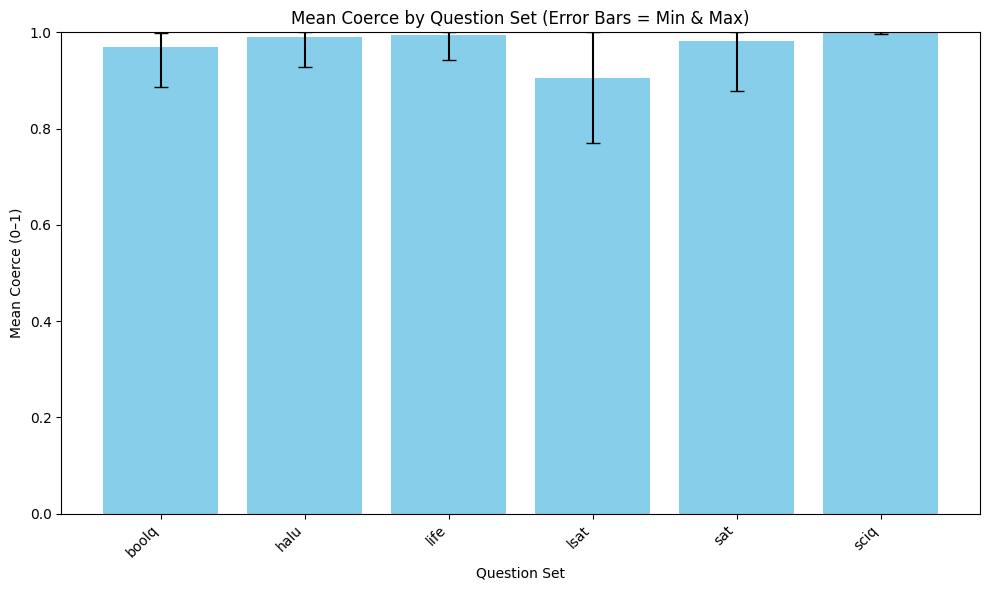

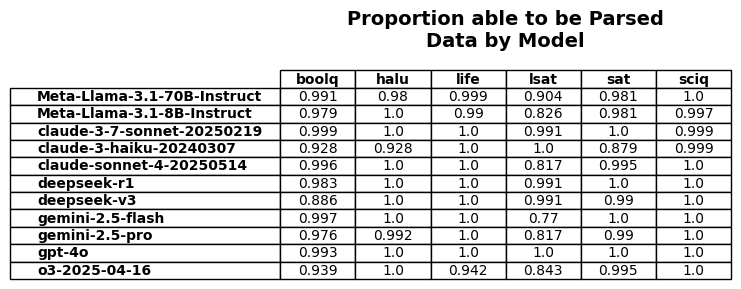

In [13]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from pathlib import Path

base_dir = Path("Parsed Results")  # change path if needed
rows = []

for provider in base_dir.iterdir():
    if provider.is_dir():
        for model_type in provider.iterdir():
            if model_type.is_dir():
                for csv_file in model_type.glob("*.csv"):
                    fname = csv_file.stem
                    question_set = fname.split("_")[0]
                    try:

                        df = pd.read_csv(csv_file)
                        mean_val = np.mean(df['coerce']) # Drops any irrelevant columns and then sees if there are any rows with incomplete sections
                        rows.append({
                            "Model Type": model_type.name,
                            "Question Set": question_set,
                            "Mean Coerce": mean_val
                        })
                    except Exception as e:
                        print(f"Error reading {csv_file}: {e}")

results_df = pd.DataFrame(rows)

# Pivot so rows = model type, columns = question set
pivot_df = results_df.pivot_table(
    index="Model Type",
    columns="Question Set",
    values="Mean Coerce",
    aggfunc="mean"
).round(3)

display(pivot_df)
# Calculate stats per question set
means = pivot_df.mean(axis=0)
mins = pivot_df.min(axis=0)
maxs = pivot_df.max(axis=0)

# Error bar values
error_lower = means - mins
error_upper = maxs - means

plt.figure(figsize=(10, 6))
plt.bar(means.index, means.values, yerr=[error_lower, error_upper], capsize=5, color='skyblue')
plt.ylim(0, 1)
plt.ylabel("Mean Coerce (0–1)")
plt.xlabel("Question Set")
plt.title("Mean Coerce by Question Set (Error Bars = Min & Max)")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


# Create a clean table image
fig, ax = plt.subplots(figsize=(8, 3))
ax.axis('off')
ax.set_title("Proportion able to be Parsed\nData by Model", fontweight='bold', fontsize=14, pad=20)
table = ax.table(
    cellText=pivot_df.round(3).values,
    colLabels=pivot_df.columns,
    rowLabels=pivot_df.index,
    cellLoc='center',
    loc='center'
)

# Styling
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.2)

# Make header bold
for (row, col), cell in table.get_celld().items():
    if row == 0 or col == -1:
        cell.set_text_props(weight='bold')

plt.tight_layout()
plt.show()

In [7]:
from pathlib import Path
import pandas as pd

def repeated_qid_counts(path, model_name, qset_name):
    # import df
    df = pd.read_csv(path)

    # Make sure "Question ID" is in df

    if 'Question ID' not in df.columns:
        raise KeyError(f"Missing column: 'Question ID'\nColumns in qset: {df.columns}")

    counts =  df['Question ID'].value_counts()
    
    is_repeat = counts > 1

    repeated_qid = is_repeat[is_repeat == True].index.to_list()


    repeat_df = pd.DataFrame(
        {
            "Question Set": qset_name,
            "Model": model_name,
            "Question ID": repeated_qid,
            "Count": counts[is_repeat]
        }
    )

    return repeat_df


def collect_repeated_qids(root="Parsed Results"):
    all_dfs = []
    root_path = Path(root)

    for model_type_dir in root_path.iterdir():
        print(model_type_dir.name)
        if not model_type_dir.is_dir():
            continue

        for model_name_dir in model_type_dir.iterdir():
            print(f"    {model_name_dir.name}")
            if not model_name_dir.is_dir():
                continue

            model_name = model_name_dir.name

            # iterate dataset files (CSV)
            for csv_path in model_name_dir.rglob("*.csv"):
                qset_name = csv_path.stem  # dataset name from file name
                print(f"        {qset_name}")
                try:
                    df_rep = repeated_qid_counts(str(csv_path), model_name, qset_name)
                    df_rep.insert(0, "Model Type", model_type_dir.name)  # optional extra context
                    all_dfs.append(df_rep)
                    if (x := len(df_rep)) == 0:

                        print(f"           ✅ Duplicate Rows: {x}")
                    else:
                        print(f"            ❌ Duplicate Rows: {x}")
                        orig_df = pd.read_csv(str(csv_path))
                        bad_qid = df_rep['Question ID']
                        dropped_df = orig_df[~orig_df['Question ID'].isin(bad_qid)].copy()

                        # overwrite original CSV
                        dropped_df.to_csv(str(csv_path), index=False)
                        print(f"                 Dropped {x*2} rows, new length {len(dropped_df)}") 
                except Exception as e:
                    # skip problematic files but continue the sweep
                    print(f"Skipping {csv_path}: {e}")

    if not all_dfs:
        return pd.DataFrame(columns=["Model Type", "Question Set", "Model", "Question ID", "Count"])

    return pd.concat(all_dfs, ignore_index=True)

# usage
final_df = collect_repeated_qids("Parsed Results")


Claude
    claude-3-7-sonnet-20250219
        boolq_valid_claude-3-7-sonnet-20250219
           ✅ Duplicate Rows: 0
        halu_eval_qa_claude-3-7-sonnet-20250219
           ✅ Duplicate Rows: 0
        life_eval_claude-3-7-sonnet-20250219
           ✅ Duplicate Rows: 0
        lsat_ar_test_claude-3-7-sonnet-20250219
           ✅ Duplicate Rows: 0
        sat_en_claude-3-7-sonnet-20250219
           ✅ Duplicate Rows: 0
        sciq_test_claude-3-7-sonnet-20250219
           ✅ Duplicate Rows: 0
    claude-3-haiku-20240307
        boolq_valid_claude-3-haiku-20240307
           ✅ Duplicate Rows: 0
        halu_eval_qa_claude-3-haiku-20240307
           ✅ Duplicate Rows: 0
        life_eval_claude-3-haiku-20240307
           ✅ Duplicate Rows: 0
        lsat_ar_test_claude-3-haiku-20240307
           ✅ Duplicate Rows: 0
        sat_en_claude-3-haiku-20240307
           ✅ Duplicate Rows: 0
        sciq_test_claude-3-haiku-20240307
           ✅ Duplicate Rows: 0
    claude-sonnet-4-20250514
 

In [8]:
# --- Fix DeepSeek naming scheme ---

rename_map = {
    "deepseek-r1": {
        "boolq_valid_deepseek-reasoner.csv": "boolq_valid_deepseek-r1.csv",
        "halu_eval_qa_deepseek-reasoner.csv": "halu_eval_qa_deepseek-r1.csv",
        "life_eval_deepseek-reasoner.csv": "life_eval_deepseek-r1.csv",
        "lsat_ar_test_deepseek-reasoner.csv": "lsat_ar_test_deepseek-r1.csv",
        "sat_en_deepseek-reasoner.csv": "sat_en_deepseek-r1.csv",
        "sciq_test_deepseek-reasoner.csv": "sciq_test_deepseek-r1.csv",
    },
    "deepseek-v3": {
        "boolq_valid_deepseek-chat.csv": "boolq_valid_deepseek-v3.csv",
        "halu_eval_qa_deepseek-chat.csv": "halu_eval_qa_deepseek-v3.csv",
        "life_eval_deepseek-chat.csv": "life_eval_deepseek-v3.csv",
        "lsat_ar_test_deepseek-chat.csv": "lsat_ar_test_deepseek-v3.csv",
        "sat_en_deepseek-chat.csv": "sat_en_deepseek-v3.csv",
        "sciq_test_deepseek-chat.csv": "sciq_test_deepseek-v3.csv",
    }
}

base_dir = "Parsed Results\\Deepseek"

for subdir, files in rename_map.items():
    for old, new in files.items():
        old_path = os.path.join(base_dir, subdir, old)
        new_path = os.path.join(base_dir, subdir, new)
        if os.path.exists(old_path):
            os.rename(old_path, new_path)
            print(f"Renamed {old} -> {new}")

Renamed boolq_valid_deepseek-reasoner.csv -> boolq_valid_deepseek-r1.csv
Renamed halu_eval_qa_deepseek-reasoner.csv -> halu_eval_qa_deepseek-r1.csv
Renamed life_eval_deepseek-reasoner.csv -> life_eval_deepseek-r1.csv
Renamed lsat_ar_test_deepseek-reasoner.csv -> lsat_ar_test_deepseek-r1.csv
Renamed sat_en_deepseek-reasoner.csv -> sat_en_deepseek-r1.csv
Renamed sciq_test_deepseek-reasoner.csv -> sciq_test_deepseek-r1.csv
Renamed boolq_valid_deepseek-chat.csv -> boolq_valid_deepseek-v3.csv
Renamed halu_eval_qa_deepseek-chat.csv -> halu_eval_qa_deepseek-v3.csv
Renamed life_eval_deepseek-chat.csv -> life_eval_deepseek-v3.csv
Renamed lsat_ar_test_deepseek-chat.csv -> lsat_ar_test_deepseek-v3.csv
Renamed sat_en_deepseek-chat.csv -> sat_en_deepseek-v3.csv
Renamed sciq_test_deepseek-chat.csv -> sciq_test_deepseek-v3.csv


## Main Plots

In [ ]:
# --- Function Definitions


from matplotlib.patches import Patch
import pandas as pd
import numpy as np
import seaborn as sns
import math as m

# base palettes per family
family_palettes = {
    "GPT":      sns.color_palette("Greens", 6),
    "Claude":   sns.color_palette("Blues", 6),
    "Gemini":   sns.color_palette("Purples", 6),
    "DeepSeek": sns.color_palette("Oranges", 6),
    "Llama":    sns.color_palette("RdPu", 6),
}


melted_dict = {}
# --- Function Definitions ---
def model_family(name: str) -> str:
    s = name.lower()
    if "gpt" in s or "o3" in s:   return "GPT"
    if "claude" in s:             return "Claude"
    if "gemini" in s:             return "Gemini"
    if "deepseek" in s:           return "DeepSeek"
    if "llama" in s:              return "Llama"
    return "other"


def pick_color(name: str) -> tuple:
    fam = model_family(name)
    pal = family_palettes[fam]
    s = name.lower()
    # Prefer consistent shades for common variants:
    if fam == "GPT":
        if "gpt-4o" in s: return pal[-2]  # darker green
        if "o3" in s:     return pal[1]   # lighter green
    if fam == "Claude":
        if "sonnet" in s: return pal[-2]
        if "haiku"  in s: return pal[2]
    if fam == "Gemini":
        if "pro"   in s:  return pal[-2]
        if "flash" in s:  return pal[2]
    if fam == "DeepSeek":
        if "r1"   in s:  return pal[-2]
        if "v3" in s:  return pal[2]
    return pal[3]  # default mid shade


def make_summary_plots(ece_rows, oc_rows, acc_rows, n_rows, num_used,
                       title_prefix="BoolQ", filename=None):
    # --- Build dataframes ---
    ece_df = pd.DataFrame(ece_rows, columns=["model", "ece", "family", "color"])
    oc_df  = pd.DataFrame(oc_rows,  columns=["model", "over_confidence", "family", "color"])
    acc_df = pd.DataFrame(acc_rows, columns=["model", "acc", "family", "color"])
    n_df   = pd.DataFrame(n_rows,   columns=["model", "n",   "family", "color"])

    # Establish model order from ECE (family then model)
    ece_df = ece_df.sort_values(["family", "model"]).reset_index(drop=True)
    model_order = ece_df["model"].tolist()

    # Reindex helpers to align models and carry family/color forward/backward
    def reorder(df):
        if df.empty:
            return df
        df = df.set_index("model").reindex(model_order).reset_index()
        for col in ("family", "color"):
            if col in df:
                df[col] = df[col].ffill().bfill()
        return df

    oc_df  = reorder(oc_df)
    acc_df = reorder(acc_df)
    n_df   = reorder(n_df)

    # --- Figure & axes (2 x 2) ---
    n_models = max(1, len(model_order))
    fig_w = max(12, 0.55 * n_models + 8)
    fig, axes = plt.subplots(2, 2, figsize=(fig_w, 10), sharex=False)
    axes = axes.flatten()

    # Order: top-left ECE, top-right OC, bottom-left ACC, bottom-right N
    panels = [
        (ece_df, "ece",             "ECE",             f"{title_prefix} — Expected Calibration Error by Model"),
        (oc_df,  "over_confidence", "Over Confidence", f"{title_prefix} — Overconfidence by Model"),
        (acc_df, "acc",             "Accuracy (%)",        f"{title_prefix} — Accuracy by Model"),
        (n_df,   "n",               "Count (n)",       f"{title_prefix} — Usable Rows by Model"),
    ]

    for ax, (df, val_col, y_label, title) in zip(axes, panels):
        
        x = df["model"] if not df.empty else []
        y = np.array(df[val_col]) if not df.empty else np.array([])

        ax.bar(x, y, color=(list(df["color"]) if not df.empty else None), linewidth=0, zorder = 2)
        ax.set_ylabel(y_label)
        ax.set_title(title)

        # Y-lims
        ymin = 0
        if val_col in ("ece"):
            ax.set_ylim(0, 1)
        else:
            ymax = (float(df[val_col].max()) if not df.empty else 0.0) * 1.10
            ymin = (float(df[val_col].min()) if not df.empty else 0.0) * 10 # this is a small number most of the time
            ax.set_ylim(min(0, ymin), max(1, ymax))

        # Horizontal reference line for N panel
        if val_col == "n":
            min_val = num_used
            ax.axhline(min_val, color="grey", linestyle="--", linewidth=1.5)
            ax.text(1.01, min_val, f"{min_val:.0f}", va="center", ha="left",
                    color="black", transform=plt.gca().get_yaxis_transform())

        if ymin < 0:
            ax.axhline(0, color="black", linestyle="-", linewidth=0.75) # y = 0 line for context
        # Rotate x labels
        ax.set_xticks(range(len(x)))
        ax.set_xticklabels(x, rotation=45, ha="right")
        ax.grid(zorder=0)

    # Legend from families present across all panels
    families_present = pd.concat(
        [df["family"] for df in (ece_df, oc_df, acc_df, n_df) if not df.empty],
        axis=0
    ).dropna().unique().tolist()

    legend_patches = []
    for fam in families_present:
        try:
            face = family_palettes.get(fam, None)
            if face is None:
                raise KeyError
            face = face[3]
        except Exception:
            face = "#cfcfcf"
        legend_patches.append(Patch(facecolor=face, label=fam))

    if legend_patches:
        axes[0].legend(handles=legend_patches, title="Model Families",
                       frameon=True, loc="upper left")

    fig.suptitle(f"Summary Statistics for {title_prefix}", fontsize=16, y=0.99)
    plt.tight_layout(rect=[0, 0, 1, 0.97])

    # Save
    if filename is None:
        filename = f"summary_bars_{title_prefix.lower()}.png"
    out_path = output_dir / filename  # assumes output_dir exists
    fig.savefig(out_path, dpi=300, bbox_inches="tight")
    plt.close(fig)
    return out_path

def compute_overconfidence_mcq(df: pd.DataFrame, qset: str):
    """
    Compute mean confidence, accuracy, and overconfidence for one LLM–question set.
    
    Parameters
    ----------
    df : pd.DataFrame
        Must contain columns ['A','B','C','D','E','Correct Answer Letter'] 
        where A–E are probabilities (floats summing to 1 per row).
    
    Returns
    -------
    dict with mean_confidence, accuracy, overconfidence
    """

    
    # Columns with option probs
    if qset == 'LSAT-AR':
        option_cols = ['A','B','C','D','E']
    else:
        option_cols = ['A','B','C','D']
    # Confidence per question = highest assigned probability
    max_probs = df[option_cols].max(axis=1)

    # For ties, find which answers are tied for max
    is_max = df[option_cols].eq(max_probs, axis=0)
    n_ties = is_max.sum(axis=1)  # number of options tied for max
    
    ## Did the correct answer get max probability?
    correct_mask = [c for c in df['Correct Answer Letter']]
    #correct_is_max = is_max.lookup(df.index, correct_mask) --- deprecated

    # Column labels of correct answers
    correct_mask = df['Correct Answer Letter']

    # Convert to numpy arrays
    rows = np.arange(len(df))
    cols = is_max.columns.get_indexer(correct_mask)

    # Get the value at (row, correct_col) for each row
    correct_is_max = is_max.to_numpy()[rows, cols]
    
    # Per-question accuracy: 1/k if correct is among ties, else 0
    per_question_acc = np.where(correct_is_max, 1/n_ties, 0)
    
    # Aggregate
    mean_conf = max_probs.mean()
    accuracy = per_question_acc.mean()
    overconf = mean_conf - accuracy
    
    return overconf

def compute_overconfidence_bool(df: pd.DataFrame):

    accuracy = np.mean(df['Correct Answer'].str.strip().str.lower() == df['Answer'].str.strip().str.lower()) # I know this is redundant I just want to make the functions similar
    conf = np.mean(df['Confidence'])

    overconf = conf - accuracy
    
    return overconf

def calibration_plot(
        scores: pd.Series, 
        confidence: pd.Series, 
        n_bins: int = 10,
        model_name: str = '',
        qset_name: str = '',
        num_complete: int = None,
        title: str = None
        ):
    # Ensure inputs are numpy arrays
    scores = scores.astype(float).to_numpy()
    #print(np.mean(scores))
    confidence = confidence.astype(float).to_numpy()
    
    # Calculate ECE and Accuracy
    ece = get_ece(pd.Series(scores), pd.Series(confidence), n_bins=n_bins)
    acc = np.mean(scores)

    melted = melt_series(score=scores, confidence=confidence)
    #display(melted)

    melted_dict[qset_name][model_name] = melted

    # Plot
    fig, ax = plt.subplots(figsize=(6, 6))

    ## Line of Well Calibration
    ax.plot([0, 1.1], [0, 1.1], linestyle='--', color='grey')

    ## Histogram:
    ax.bar(
        melted['mean_confidence'].fillna(0), 
        melted['count'].fillna(0) / melted['count'].sum(), 
        width=0.025, 
        align='center', 
        edgecolor='white',
        color = 'orange'
        )
    ax.scatter(melted['mean_confidence'], melted['mean_score'])


    ## Error Bars:
    # Standard error for a proportion
    stderr = np.sqrt((melted['mean_score'] * (1 - melted['mean_score'])) / melted['count'])
    stderr = stderr.fillna(0)  # no error if count = 0 or NaN

    ax.errorbar(melted['mean_confidence'], 
                melted['mean_score'], 
                yerr = stderr,  
                fmt='o', 
                ecolor='grey', 
                capsize=5,
                #linestyle = 'none'
                )
    
    ax.scatter(melted['mean_confidence'], melted['mean_score'], color = 'blue')


    # 45-degree reference line


    ax.set_xlim(0, 1.1)
    ax.set_ylim(0, 1.1)
    ax.set_xlabel('Stated Confidence')
    ax.set_ylabel('Average Accuracy', labelpad= 15)
    if title is not None:
        ax.set_title(f'{title}\nECE: {ece:.3f} | Accuracy: {acc:.3f} | n = {num_complete}')
    else:
        ax.set_title(f'Calibration Plot for {model_name} on {qset_name}\nECE: {ece:.3f} | Accuracy: {acc:.3f} | n = {num_complete}' )
    ticks = [0, 0.1, 0.2, 0.3,0.4, 0.5, 0.6,0.7,0.7,0.8,0.9,1.0]
    labels = [0, 0.1, 0.2, 0.3,0.4, 0.5, 0.6,0.7,0.7,0.8,0.9,1.0]
    ax.set_xticks(ticks= ticks, labels=labels)

    # Create a secondary y-axis for proportion
    ax2 = ax.twinx()
    ax.set_ylim(0, 1.1)
    ax2.set_ylabel('Proportion of Stated Confidence',rotation=-90, labelpad= 15)

    ax.set_ylim(0, 1.1)
    ax2.set_ylim(0, 1.1)
    #ax.grid(False)   # turn off grid for left axis
    #ax2.grid(False)  # turn off grid for right axis


    # --- Save Plot ---
    filename = f"cal_plot_{qset_key.lower()}_{model_key}.png"
    out_path = output_dir / "Calibration Plots"  / filename  # assumes output_dir exists
    fig.savefig(out_path, dpi=300, bbox_inches="tight")
    plt.close(fig)
    
    #plt.tight_layout()
    #plt.show()

    return ece, acc
    
def mcq_calibration_plot(df: pd.DataFrame,
        options: list = [],
        gold_column: str = 'Correct Answer Letter',
        answer_column: str = 'Answer',
        n_bins: int = 10,
        model_name: str = '',
        qset_name: str = '',
        num_complete: int = None,
        title: str = None,
        show = False,
        save = True
        ):
    

    # Calculate ECE and Accuracy before melting df

    summary_df =  pd.DataFrame({
        "answer": df[options].idxmax(axis=1),      # letter with max prob
        "confidence": df[options].max(axis=1)      # highest prob
    })
    summary_df['score'] = summary_df['answer'].str.lower().str.strip().str.replace('_prob', '') == df[gold_column].str.lower().str.strip()
    

    ece = get_ece(summary_df["score"], summary_df["confidence"], n_bins=n_bins)
    acc = np.mean(summary_df["score"])


    # Now melt df to get what we need for plots
    melted = df.melt(
        id_vars=['Question ID', gold_column],
        value_vars=options,
        var_name='Option',
        value_name='confidence'
        )


    melted = melted.sort_values(["Question ID", "Option"])


    #print(full_df.shape)

    melted['score'] = (melted[gold_column].str.strip() == melted['Option'].str.replace('_prob', '')).astype(int)
    
    scores = melted['score']
    confidence = melted['confidence']

    

    melted = melt_series(score=scores, confidence=confidence)
    #display(melted)

    melted_dict[qset_name][model_name] = melted

    # Plot
    fig, ax = plt.subplots(figsize=(6, 6))

    ## Line of Well Calibration
    ax.plot([0, 1.1], [0, 1.1], linestyle='--', color='grey')

    ## Histogram:
    ax.bar(
        melted['mean_confidence'].fillna(0), 
        melted['count'].fillna(0) / melted['count'].sum(), 
        width=0.025, 
        align='center', 
        edgecolor='white',
        color = 'orange'
        )
    ax.scatter(melted['mean_confidence'], melted['mean_score'])


    ## Error Bars:
    # Standard error for a proportion
    stderr = np.sqrt((melted['mean_score'] * (1 - melted['mean_score'])) / melted['count'])
    stderr = stderr.fillna(0)  # no error if count = 0 or NaN

    ax.errorbar(melted['mean_confidence'], 
                melted['mean_score'], 
                yerr = stderr,  
                fmt='o', 
                ecolor='grey', 
                capsize=5,
                #linestyle = 'none'
                )
    
    ax.scatter(melted['mean_confidence'], melted['mean_score'], color = 'blue')


    # 45-degree reference line


    ax.set_xlim(0, 1.1)
    ax.set_ylim(0, 1.1)
    ax.set_xlabel('Stated Confidence')
    ax.set_ylabel('Average Accuracy', labelpad= 15)
    if title is not None:
        ax.set_title(f'{title}\nECE: {ece:.3f} | Accuracy: {acc:.3f} | n = {num_complete}')
    else:
        ax.set_title(f'Calibration Plot for {model_name} on {qset_name}\nECE: {ece:.3f} | Accuracy: {acc:.3f} | n = {num_complete}' )
    ticks = [0, 0.1, 0.2, 0.3,0.4, 0.5, 0.6,0.7,0.7,0.8,0.9,1.0]
    labels = [0, 0.1, 0.2, 0.3,0.4, 0.5, 0.6,0.7,0.7,0.8,0.9,1.0]
    ax.set_xticks(ticks= ticks, labels=labels)

    # Create a secondary y-axis for proportion
    ax2 = ax.twinx()
    ax.set_ylim(0, 1.1)
    ax2.set_ylabel('Proportion of Stated Confidence',rotation=-90, labelpad= 15)

    ax.set_ylim(0, 1.1)
    ax2.set_ylim(0, 1.1)
    #ax.grid(False)   # turn off grid for left axis
    #ax2.grid(False)  # turn off grid for right axis


    # --- Save Plot ---
    filename = f"cal_plot_{qset_key.lower()}_{model_key.replace("'", "")}.png"
    out_path = output_dir / "Calibration Plots"  / filename  # assumes output_dir exists
    
    if save:
        fig.savefig(out_path, dpi=300, bbox_inches="tight")
        plt.close(fig)
    if show:
        plt.tight_layout()
        plt.show()

    return ece, acc

def get_ece(score: pd.Series, confidence: pd.Series, n_bins: int = 10):
    # Ensure inputs are clean
    score = score.astype(float)
    confidence = confidence.astype(float)

    # Bin edges and assignments
    bin_edges = np.linspace(0.0, 1.0, n_bins + 1)
    bin_ids = np.digitize(confidence, bin_edges, right=True)

    ece = 0.0
    total_count = len(score)

    # Calculate ECE per bin
    for i in range(1, n_bins + 1):
        bin_mask = bin_ids == i
        bin_count = bin_mask.sum()
        
        if bin_count > 0:
            bin_accuracy = score[bin_mask].mean()
            bin_confidence = confidence[bin_mask].mean()
            ece += (bin_count / total_count) * abs(bin_accuracy - bin_confidence)

    return ece

def sum_token_logprobs_boolq(old_df: pd.DataFrame):
    df = old_df.copy()
    truthy = ['True', 'true', 'TRUE', 'yes', 'Yes']
    falsey = ['False', 'false', 'FALSE', 'no', 'No']

    # Strip spaces for all t-columns
    t_cols = [f"t{i}" for i in range(1, 6)]
    p_cols = [f"t{i}_prob" for i in range(1, 6)]
    df[t_cols] = df[t_cols].apply(lambda col: col.str.strip())

    # Boolean masks for truthy/falsey per cell
    mask_truthy = df[t_cols].isin(truthy)
    mask_falsey = df[t_cols].isin(falsey)

    # Multiply masks by probability columns (automatically aligns column-wise)
    df["true_sum"] = (mask_truthy * df[p_cols].to_numpy()).sum(axis=1)
    df["false_sum"] = (mask_falsey * df[p_cols].to_numpy()).sum(axis=1)

    t_prob = df['true_sum'] / (df['false_sum'] + df['true_sum'])
    f_prob = df['false_sum'] / (df['false_sum'] + df['true_sum'])

    df['true_token_prob'] = t_prob
    df['false_token_prob'] = f_prob

    return df

def add_confidence_bin(df: pd.DataFrame, col: str = 'confidence') -> pd.DataFrame:
    # Copy to avoid modifying original
    df = df.copy()

    # Clip confidence to [0, 1]
    df[col] = df[col].clip(0, 1)

    # Define bin edges and labels
    bins = np.linspace(0, 1, 11)        # 0.0, 0.1, ..., 1.0
    bins = np.append(bins, 1.0000001)    # ensure 1.0 is captured in last bin
    labels = [round(x, 1) for x in np.linspace(0.1, 1.0, 11)]

    # Assign bin label
    df['bin'] = pd.cut(
        df[col],
        bins=bins,
        labels=labels,
        ordered= False,
        right=False,   # (a, b] style
        include_lowest=False
    )

    return df

def melt_series(score, confidence):
    df = pd.DataFrame({'confidence': confidence, 'score': score})
    df = add_confidence_bin(df)
    df['score'] = df['score'].astype('float')
    #print('Binned DF:')
    #display(df)
    # Group by confidence and aggregate
    melt_df = df.groupby('bin', observed=False).agg(
        #observed=True,
        mean_score=('score', 'mean'),
        count=('score', 'size'),
        mean_confidence = ('confidence', 'mean')
    ).reset_index()


    return melt_df

def qid_to_rads(qid: pd.Series)-> pd.Series:
    radius_list = [1, 5, 10, 20]
    mod_qid = qid.astype('int').apply(lambda x: x % 4)
    rads = mod_qid.apply(lambda i: radius_list[i])
    return rads


def score_life_eval(df, act_table):
    answers = df['Answer']
    confidence = df['Confidence']
    qid = df['Question ID']

    # Get Radius
    radius_list = [1, 5, 10, 20]
    # Get the modulus of QID then use that as an index for radius_list such that 0-> 1, 1-> 5, 2-> 10, 3-> 20
    mod_qid = df['Question ID'].astype('int').apply(lambda x: x % 4)


    rads = qid_to_rads(qid)
    #df['radius'] = rads

    #Gold Answer:

    all_data = pd.DataFrame({
        'Question ID': qid,
        'Answer': answers,
        'Confidence': confidence.astype(float),
        'Radius': rads,
    })

    data = all_data[all_data['Answer'].notna()].copy()
    data['Gender'] = ['female' if i >= 404 else 'male' for i in df.index]
    data['Age'] = [get_age(qid) for qid in df['Question ID']]


    data['Score'] = data.apply(lambda row: compute_prob(
        point_estimate= row['Answer'],
        min_age= row['Age'],
        gender= row['Gender'],
        R= row['Radius'],
        df = act_table
        ),
        axis = 1
        )

    data['Overconfidence'] = (data['Confidence'] - data['Score'])
    return data

def get_age(qid: int) -> int:
    if qid < 404:
        return m.floor(
            abs(
                (qid) / 4
                )
            )
    else:
        return m.floor(
            abs(
                (qid - 404) / 4
                )
            )

def compute_prob(point_estimate: float,
                 R: float,
                 gender: str,          # 'male' or 'female' (case-insensitive)
                 min_age: int,         # condition "already lived at least min_age"
                 df: pd.DataFrame) -> float:
    """
    Using a life table with columns:
      - 'Age'
      - 'Death probability (MALE)'
      - 'Death probability (FEMALE)'
    compute P(death occurs within [point_estimate - R, point_estimate + R] | survived to min_age).
    """

    if "Age" not in df.columns:
        raise ValueError("Expected an 'Age' column in the life table.")

    g = gender.strip().lower()
    if g not in ("male", "female"):
        raise ValueError("gender must be 'male' or 'female'")

    qx_col_map = {
        "male":   "Death probability (MALE)",
        "female": "Death probability (FEMALE)",
    }
    qx_col = qx_col_map[g]
    if qx_col not in df.columns:
        raise ValueError(f"Expected column '{qx_col}' in the life table.")

    # Work on a clean copy sorted by Age
    tab = df[["Age", qx_col]].copy().sort_values("Age").reset_index(drop=True)
    tab.rename(columns={qx_col: "q"}, inplace=True)
    tab["Age"] = tab["Age"].astype(int)
    tab["q"] = tab["q"].astype(float)

    # Integer-age window [lo, hi), clamped to table bounds and min_age
    table_min = int(tab["Age"].min())
    table_max = int(tab["Age"].max())  # last age with q_x for [x, x+1)
    lo = max(int(np.floor(point_estimate - R)), int(min_age), table_min)
    hi = min(int(np.ceil(point_estimate + R)), table_max + 1)  # exclusive upper bound

    if hi <= lo:
        return 0.0

    # Align to contiguous ages and extract q_x as numpy
    ages = np.arange(table_min, table_max + 1, dtype=int)
    sub = tab.set_index("Age").reindex(ages)
    if sub["q"].isna().any():
        # restrict to contiguous valid block if necessary
        valid = sub["q"].notna()
        first = int(ages[valid.argmax()])
        last = int(ages[::-1][valid.iloc[::-1].argmax()])
        lo = max(lo, first)
        hi = min(hi, last + 1)
        if hi <= lo:
            return 0.0
        sub = sub.loc[first:last]
        ages = sub.index.values

    q = sub["q"].to_numpy()
    offset = int(ages[0])

    # Survival from min_age (m)
    m = max(int(min_age), int(ages[0]))
    if m >= hi:
        return 0.0

    one_minus_q = 1.0 - q
    start = m - offset
    end_excl = hi - offset

    # Relative survival S_rel(x) = Π_{k=m}^{x-1} (1-q_k), with S_rel(m)=1
    S_rel = np.ones(end_excl - start + 1, dtype=float)
    if end_excl - start > 0:
        S_rel[1:] = np.cumprod(one_minus_q[start:end_excl])

    # Sum P(T in [x, x+1) | T >= m) = S_rel(x) * q_x for x = max(lo,m) .. hi-1
    x0 = max(lo, m)
    xs = np.arange(x0, hi, dtype=int)
    if xs.size == 0:
        return 0.0

    idx = xs - offset
    S_rel_x = S_rel[(xs - m)]
    q_x = q[idx]
    prob = float(np.sum(S_rel_x * q_x))

    # Clamp for numerical safety
    return max(0.0, min(1.0, prob))

def get_gini(df):
    options = ['A', 'B', 'C', 'D', 'E']
    
    return df.apply(
        lambda row: gini([float(row[opt]) for opt in options if opt in row and pd.notna(row[opt])]),
        axis=1
    )

def gini(x: list):
    # (Warning: This is a concise implementation, but it is O(n**2)
    # in time and memory, where n = len(x).  *Don't* pass in huge
    # samples!)

    # Mean absolute difference
    mad = np.abs(np.subtract.outer(x, x)).mean()
    # Relative mean absolute difference
    rmad = mad/np.mean(x)
    # Gini coefficient
    g = 0.5 * rmad
    return g



### Run Main Plots

In [580]:
## Make All Plots
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os
from matplotlib.patches import Patch

model_names = {
    "GPT": {
        "gpt-4o": "GPT-4o",
        "o3-2025-04-16": "GPT-o3",
    },
    "Claude":{
        "claude-sonnet-4-20250514": "Claude-Sonnet-4",
        "claude-3-7-sonnet-20250219": "Claude-Sonnet-3.7",
        "claude-3-haiku-20240307": "Claude Haiku 3",
    },
     "Llama":{
         "Meta-Llama-3.1-8B-Instruct": "Llama-3.1-8B",
         "Meta-Llama-3.1-70B-Instruct": "Llama-3.1-70B",
    },
    "Gemini":{
        "gemini-2.5-pro": "Gemini-2.5-Pro",
        "gemini-2.5-flash": "Gemini-2.5-Flash"
    },
    "Deepseek": {
        "deepseek-r1": "DeepSeek-R1",
        "deepseek-v3": "DeepSeek-V3"
    },
}

qsets = {
    "boolq_valid": "BoolQ",
    "halu_eval_qa": "HaluEval",
    "life_eval": "LifeEval", 
    "lsat_ar_test": "LSAT-AR",
    "sat_en": "SAT-EN",
    "sciq_test": "SciQ"

}

response_map = {
    'true': True,
    'false': False,
    'a': 'A',
    'b': 'B',
    'c': 'C',
    'd': 'D',
    'e': 'E'
}

mcq_qsets = ['LSAT-AR', 'SAT-EN', 'SciQ']

summary_stats = {}

folder = "Parsed Results"
folder_gold = "Formatted Benchmarks"
dfs = {}  # store DataFrames in a dict keyed by (qset_name, model_display)
completions = {}
raw_dfs = {}
melted_dict = {}

n_used_dict = {}

model_token_ece = {
    "Llama-3.1-8B": {},
    "Llama-3.1-70B": {},
    "GPT-4o": {}
}

for qset_key, qset_name in qsets.items():
    summary_stats[qset_name] = {}
    melted_dict[qset_name] = {}
    print(f"{qset_name}:")
    output_dir = Path("Plots") / qset_name
    output_dir.mkdir(parents=True, exist_ok=True)
    dfs[qset_name] = {}
    completions[qset_name] = {}
    # Get gold_df for this qset
    gold_filename =  f"{qset_key}_formatted.csv"
    gold_path = os.path.join(folder_gold, gold_filename)
    print(f"    ✅{gold_filename}")
    if os.path.exists(gold_path):
        gold_df = pd.read_csv(gold_path)
    else:
        print(f"Missing gold file: {gold_path}")
        gold_df = None
        continue
    
    for model_group, models in model_names.items():
        print(f"    {model_group}:")

        # --- Iterate over each model in group ---
        for model_key, model_display in models.items():
            filename = f"{qset_key}_{model_key}.csv"
            filepath = os.path.join(folder, model_group, model_key, filename)
            completions[model_display] = {}
            # --- Get the Parsed Result CSV ---
            if os.path.exists(filepath):
                df = pd.read_csv(filepath)
                dfs[qset_name][model_display] = df
                print(f"        ✅{filename}")
            else:
                print(f"Missing: {filepath}")


            n = df['coerce'].sum()                        #------HERE

            completions[qset_name][model_display] = n

    print(f"✅All Dataframes Imported for {qset_name}!\nRunning Analysis:")

    # --- Find Usable IDs ---
    # if qset_name != 'LifeEval' and qset_name != 'HaluEval':                 # Add logic for these two
    #     continue
    if qset_name != 'HaluEval' and qset_name != 'LifeEval':
        models_dict = dfs[qset_name]
        valid_ids = {
            qset_name: set.intersection(*[
                set(
                    df.loc[
                        (df['Answer'].astype(str).str.strip().str.lower() # df['coerce'] == True
                                .map(response_map).notna()) &
                        (df['coerce'] == True),
                        'Question ID'
                        ]
                    )
                for df in models_dict.values()
            ])
            #for qset_name, models_dict in dfs.items()
        }
        
    elif qset_name == 'HaluEval':
        models_dict = dfs[qset_name]
        valid_ids = {
            qset_name: set.intersection(*[
                set(
                    df.loc[
                        df['Confidence'].notna(),  # HaluEval only looks for confidence values
                        'Question ID'
                        ]
                    )
                for df in models_dict.values()
            ])
            #for qset_name, models_dict in dfs.items()
        }
    elif qset_name == 'LifeEval':
        models_dict = dfs[qset_name]
        valid_ids = {
            qset_name: set.intersection(*[
                set(
                    df.loc[
                        (pd.to_numeric( df['Answer'], errors='coerce').notna()) &
                        (pd.to_numeric( df['Confidence'], errors='coerce').notna()),
                        'Question ID'
                    ]
                )
                for df in models_dict.values()
            ])
        }

    # --- Convert DFs to only usable IDs ---
    ids = {str(x) for x in valid_ids[qset_name]}
    gold_df = gold_df[gold_df['Question ID'].astype(str).isin(ids)].reset_index(drop=True)
    print(f"Usable Rows: {len(ids)}")                                         # This doesn't match with the n outputted? Must debug
    old_dfs = dfs.copy()
    for model_display, df in dfs[qset_name].items():

        mask = df['Question ID'].astype(str).isin(ids)

        #print(gold_df.columns)
        
        dfs[qset_name][model_display] = df.loc[mask].copy()

    # --- Run Summary Analysis ---                                            # This method may not be best implementation.

    ece_rows = []
    acc_rows = []
    n_rows = []
    oc_rows = []
    gini_rows = []
    n_used = len(ids)

    n_used_dict[qset_name] = len(ids)


    for model_group, models in model_names.items():
        for model_key, model_display in models.items():

            # --- Get Response Confidence and Scores Series ---                 
            if qset_name == 'BoolQ': 
                df = dfs[qset_name][model_display]
                response_orig = df['Answer']
                response = (response_orig.astype(str).str.strip().str.lower()
                            .map(response_map)
                            ).reset_index(drop = True)
                confidence = df['Confidence']
                scores = gold_df['Correct Answer'] == response.astype('bool')
            elif qset_name == 'HaluEval':
                df =  dfs[qset_name][model_display]                             
                confidence = df['Confidence'] 
                scores = df['Question ID'].str.contains('_r') # Marker for real/ hallucinated answer

            elif qset_name == 'LifeEval':
                df = dfs[qset_name][model_display]
                #print(f"USING {df.shape[0]} ROWS")
                # Get Radius
                radius_list = [1, 5, 10, 20]
                # Get the modulus of QID then use that as an index for radius_list such that 0-> 1, 1-> 5, 2-> 10, 3-> 20
                mod_qid = df['Question ID'].astype('int').apply(lambda x: x % 4)


                rads = mod_qid.apply(lambda i: radius_list[i])
                df['radius'] = rads


                # Get Answer:

                response = df['Answer']



                act_table = pd.read_csv("Formatted Benchmarks\\PeriodLifeTable_2022_RawData.csv").dropna()
                scores_df = score_life_eval(df, act_table)

                merged = df.merge(
                    scores_df,
                    on="Question ID",
                    how="inner",        # or "left"/"right"/"outer" depending on what you want
                    suffixes=("", "_dup")  # keep df’s names as-is, add "_dup" to scores_df duplicates
                )

                # Drop the duplicate columns if they exist
                dup_cols = [c for c in merged.columns if c.endswith("_dup")]
                merged = merged.drop(columns=dup_cols)

                df = merged.copy()


                confidence = df['Confidence']
                
                scores = df['Score']

                dfs[qset_name][model_display] = df

            elif qset_name == 'LSAT-AR':
                full_df = dfs[qset_name][model_display]
                full_df = full_df.drop_duplicates(subset=["Question ID"], keep="last")

                full_df = full_df.merge(
                    gold_df[['Question ID', 'Correct Answer Letter']],
                    on='Question ID',
                    how='inner',
                    validate='one_to_one'
                )

                answer_options = ['A', 'B', 'C', 'D', 'E']
                gold_column_name = "Correct Answer Letter"
            elif qset_name == 'SAT-EN':

                full_df = dfs[qset_name][model_display]


                full_df = full_df.merge(
                    gold_df[['Question ID', 'Correct Answer Letter']],
                    on='Question ID',
                    how='inner',
                    validate='one_to_one'
                )

                answer_options = ['A', 'B', 'C', 'D']
                gold_column_name = "Correct Answer Letter"
            elif qset_name == 'SciQ':
                full_df = dfs[qset_name][model_display]


                full_df = full_df.merge(
                    gold_df[['Question ID', 'Correct Answer Letter']],
                    on='Question ID',
                    how='inner',
                    validate='one_to_one'
                )

                answer_options = ['A', 'B', 'C', 'D']
                gold_column_name = "Correct Answer Letter"
            else:
                print(f'Invalid Q-Set! {qset_name} not found!')

            # --- Multiple Choice Question Calibration Plots ---
            if qset_name in mcq_qsets:
                full_df['Gini'] = get_gini(full_df)
                
                
                ece, acc = mcq_calibration_plot(full_df, 
                                                options= answer_options, 
                                                gold_column= gold_column_name, 
                                                model_name = model_display, 
                                                qset_name = qset_name, 
                                                num_complete = n_used
                                                )
                acc = acc * 100

                #n = old_dfs[qset_name][model_display]['answer'].notna().sum()
                n = completions[qset_name][model_display]

                over_confidence = compute_overconfidence_mcq(full_df, qset_name)
                #summary_df['answer'].str.lower().str.strip() == df[gold_column].str.lower().str.strip()
                full_df['Score'] = (full_df['Answer'].str.lower().str.strip() == full_df['Correct Answer Letter'].str.lower().str.strip()).astype(int)
                mean_gini = np.mean(full_df['Gini'])
                dfs[qset_name][model_display] = full_df
                gini_rows.append((model_display, mean_gini, fam, color))
                
                #-- Token Probs -- 
                if ('Llama' in model_display) or ('GPT-4o' == model_display):
                    new_answer_options = [item + '_prob' for item in answer_options]
                    
                    model_key = model_key + '_tokens'
                    token_ece, token_acc = mcq_calibration_plot(full_df, 
                                options= new_answer_options, 
                                gold_column= gold_column_name, 
                                model_name = model_display + "'s Tokens", 
                                qset_name = qset_name, 
                                num_complete = n_used
                                )
                    
                    model_token_ece[model_display][qset_name] = token_ece
                    
                    
                    

             # --- Make Calibration Plot --- 
            else:
                n = completions[qset_name][model_display]
                acc = np.mean(scores) *100
                ece = get_ece(scores, confidence)
                over_confidence = np.mean(confidence.astype(float)) - np.mean(scores.astype(float)) 
                calibration_plot(scores = scores, confidence = confidence, model_name = model_display, qset_name = qset_name, num_complete = n_used)

                if ('Llama' in model_display) or ('GPT-4o' == model_display):
                    if qset_name == 'LifeEval':
                        token_prob = df['Answer_prob']
                        token_ece, token_acc = calibration_plot(scores = scores, confidence = token_prob, model_name = model_display + "'s Tokens", qset_name = qset_name, num_complete = n_used)
                        model_token_ece[model_display][qset_name] = token_ece
                        
                    elif qset_name == 'BoolQ':
                        token_prob = df[['True_prob', 'False_prob']].max(axis=1)
                        token_ece, token_acc = calibration_plot(scores = scores, confidence = token_prob, model_name = model_display + "'s Tokens", qset_name = qset_name, num_complete = n_used)
                        model_token_ece[model_display][qset_name] = token_ece




            # --- Summary Stats ---
            print(f"Raw Summary Stats: {model_display}")
            print(f"                Accuracy: {acc:.2f}%")
            print(f"         Overconfidence: {over_confidence}")
            print(f"                     ECE: {ece:.3f}")
            print(f"                       n: {n}")

            # --- Add Summary Stats ---
            fam = model_family(model_display)
            color = pick_color(model_display)
            ece_rows.append((model_display, float(ece), fam, color))
            acc_rows.append((model_display, acc, fam, color))
            n_rows.append((model_display, float(n), fam, color))
            oc_rows.append((model_display, over_confidence, fam, color))
            

            
    # --- Analysis Plots ---
    output_dir = Path("Plots") / qset_name 
    output_dir.mkdir(parents=True, exist_ok=True)
    if qset_name in mcq_qsets:
        summary_stats[qset_name] = {
            'n': n_rows,
            'accuracy': acc_rows,
            'ece': ece_rows,
            'over_confidence': oc_rows,
            'mean_gini': gini_rows
        }
    else:
        summary_stats[qset_name] = {
            'n': n_rows,
            'accuracy': acc_rows,
            'ece': ece_rows,
            'over_confidence': oc_rows,
        }
    
    make_summary_plots(ece_rows, oc_rows, acc_rows, n_rows, n_used, title_prefix = qset_name) #TODO --- Fix this for LifeEval



BoolQ:
    ✅boolq_valid_formatted.csv
    GPT:
        ✅boolq_valid_gpt-4o.csv
        ✅boolq_valid_o3-2025-04-16.csv
    Claude:
        ✅boolq_valid_claude-sonnet-4-20250514.csv
        ✅boolq_valid_claude-3-7-sonnet-20250219.csv
        ✅boolq_valid_claude-3-haiku-20240307.csv
    Llama:
        ✅boolq_valid_Meta-Llama-3.1-8B-Instruct.csv
        ✅boolq_valid_Meta-Llama-3.1-70B-Instruct.csv
    Gemini:
        ✅boolq_valid_gemini-2.5-pro.csv
        ✅boolq_valid_gemini-2.5-flash.csv
    Deepseek:
        ✅boolq_valid_deepseek-r1.csv
        ✅boolq_valid_deepseek-v3.csv
✅All Dataframes Imported for BoolQ!
Running Analysis:
Usable Rows: 2503
Raw Summary Stats: GPT-4o
                Accuracy: 85.30%
         Overconfidence: 0.07960047942469028
                     ECE: 0.080
                       n: 3247
Raw Summary Stats: GPT-o3
                Accuracy: 86.06%
         Overconfidence: -0.034662405113863426
                     ECE: 0.044
                       n: 3070
Raw Summary S

In [531]:
act_table

,Age,Death probability (MALE),Number of lives (MALE),Life expectancy (MALE),Death probability (FEMALE),Number of lives (FEMALE),Life expectancy (FEMALE)
0,0.0,0.006064,"100,000",74.74,0.005119,"100,000",80.18
1,1.0,0.000491,"99,394",74.20,0.000398,"99,488",79.60
2,2.0,0.000309,"99,345",73.23,0.000240,"99,449",78.63
3,3.0,0.000248,"99,314",72.25,0.000198,"99,425",77.65
4,4.0,0.000199,"99,290",71.27,0.000160,"99,405",76.66
...,...,...,...,...,...,...,...
114,114.0,0.788125,0,0.75,0.788125,0,0.75
115,115.0,0.827531,0,0.70,0.827531,0,0.70
116,116.0,0.868907,0,0.64,0.868907,0,0.64
117,117.0,0.912353,0,0.59,0.912353,0,0.59


In [217]:
dfs['SAT-EN']['Llama-3.1-70B']['Answer'].isin(['A', 'B', 'C', 'D']).sum()


sat = dfs['SAT-EN']['Llama-3.1-70B'].copy()

sat[sat['Answer'].isin(['A', 'B', 'C', 'D']).sum() & sat['coerce']].isna().sum()


#Gini

sat[sat['Gini'].isna()]


,Unnamed: 0,Question ID,Answer,A,B,C,D,coerce,content,Question ID.1,A_prob,B_prob,C_prob,D_prob,Correct Answer Letter,Gini,Score


## Special Plots

In [54]:
# Combined Calibration plot
inverted = {}
for outer_key, inner_dict in melted_dict.items():
    for inner_key, value in inner_dict.items():
        if inner_key not in inverted:
            inverted[inner_key] = {}
        inverted[inner_key][outer_key] = value

In [57]:
def weight_avg_df(model_dict): # Do this for each model
    weighted_dict = {}
    # Makes a weighted average of each model
    merged = pd.DataFrame({
        'bin': [0.1, 0.2, 0.3, 0.4 ,0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
    })

    #First Merge them all in one
    for qset_name, df in model_dict.items():
        rename_map = {c: f"{c}_{qset_name}" for c in df.columns if c != "bin"}
        df_renamed = df.rename(columns=rename_map)

        merged = pd.merge(merged, df_renamed, on="bin", how="outer").infer_objects(copy=False).fillna(0)

        # Identify score, count, and confidence columns
    score_cols = [c for c in merged.columns if c.startswith("mean_score_")]
    count_cols = [c for c in merged.columns if c.startswith("count_")]
    conf_cols  = [c for c in merged.columns if c.startswith("mean_confidence_")]

    # Convert counts to total count per bin
    total_counts = merged[count_cols].sum(axis=1)

    # Weighted averages
    weighted_score = (merged[score_cols].multiply(merged[count_cols].values).sum(axis=1) / total_counts.replace(0, 1))
    weighted_conf  = (merged[conf_cols].multiply(merged[count_cols].values).sum(axis=1) / total_counts.replace(0, 1))

    return pd.DataFrame({
        "bin":  [0.1, 0.2, 0.3, 0.4 ,0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        "mean_confidence": weighted_conf,
        "mean_score": weighted_score,
        "count": total_counts

    })



In [58]:
full_merge = {}

for model_name, model_dict in inverted.items():
    full_merge[model_name] = weight_avg_df(model_dict=model_dict)

full_merge_df = weight_avg_df(full_merge)
full_merge_df

,bin,mean_confidence,mean_score,count
0,0.1,0.014027,0.020588,48011
1,0.2,0.107600,0.053192,6322
2,0.3,0.230390,0.146740,2574
3,0.4,0.350040,0.324572,358
4,0.5,0.551034,0.472408,3026
5,0.6,0.690557,0.628510,4120
6,0.7,0.753554,0.803555,1099
7,0.8,0.820478,0.735633,9178
8,0.9,0.949377,0.798923,38672
9,1.0,1.000000,0.774385,13625


### Only MCQ

In [208]:
melted_dict.keys()

dict_keys(['BoolQ', 'HaluEval', 'LifeEval', 'LSAT-AR', 'SAT-EN', 'SciQ'])

In [393]:
mcq_merge = {}
# Combined Calibration plot
mcq_inverted = {}
for outer_key, inner_dict in melted_dict.items():
    if outer_key not in mcq_qsets:
        continue
    for inner_key, value in inner_dict.items():
        if inner_key not in mcq_inverted:
            mcq_inverted[inner_key] = {}
        mcq_inverted[inner_key][outer_key] = value



for model_name, model_dict in mcq_inverted.items():
    full_merge[model_name] = weight_avg_df(model_dict=model_dict)

mcq_merge_df = weight_avg_df(full_merge)
mcq_merge_df

,bin,mean_confidence,mean_score,count
0,0.1,0.012522,0.024616,49277
1,0.2,0.105021,0.049472,5680
2,0.3,0.216227,0.141958,1430
3,0.4,0.349763,0.285714,49
4,0.5,0.541810,0.584735,773
5,0.6,0.694515,0.846073,955
6,0.7,0.751686,0.913669,278
7,0.8,0.822733,0.909026,2781
8,0.9,0.961807,0.928658,9910
9,1.0,1.000000,0.904567,3657


In [394]:

np.mean(full_merge_df['mean_score'] ), np.mean(mcq_merge_df['mean_score'])

(0.47585058109653994, 0.5588487304214548)

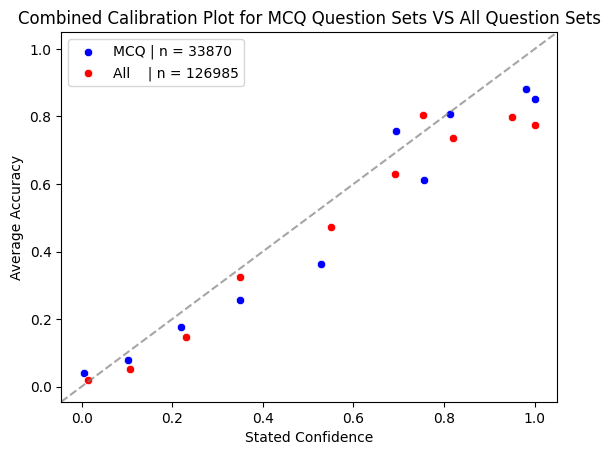

In [392]:
sns.scatterplot(mcq_merge_df,  x= 'mean_confidence', y = 'mean_score', color = 'b', label =f'MCQ | n = {sum(mcq_merge_df['count'])}', legend= 'auto')
sns.scatterplot(full_merge_df, x= 'mean_confidence', y= 'mean_score',  color = 'r', label = f'All    | n = {sum(full_merge_df['count'])}', legend= 'auto')
 
lims = [
    min(plt.xlim()[0], plt.ylim()[0]),
    max(plt.xlim()[1], plt.ylim()[1])
]
plt.plot(lims, lims, '--', color='grey', alpha=0.7)
plt.xlim(lims)
plt.ylim(lims)

plt.title('Combined Calibration Plot for MCQ Question Sets VS All Question Sets')
plt.xlabel('Stated Confidence')
plt.ylabel('Average Accuracy')
#plt.show()
plt.savefig("Plots\\Summary Plots\\combined_cal_plot_mcqV_all.png", dpi = 450)


## Summary Table

In [271]:
import pandas as pd

metrics = ["accuracy", "n", "ece", "over_confidence", "mean_gini"]
rows = []

for dataset, dataset_dict in summary_stats.items():
    for metric in metrics:
        row = {"Question Set": dataset, "Metric": metric}
        
        if metric not in dataset_dict:
            continue
        
        for entry in dataset_dict[metric]:
            # unpack tuple
            model_name = entry[0]
            metric_value = entry[1]
            # the rest of entry (entry[2:]) is extra info you may ignore
            row[model_name] = metric_value
        
        rows.append(row)

# Build DataFrame
table_df = pd.DataFrame(rows)

# Set multi-index for nice formatting
table_df = table_df.set_index(["Question Set", "Metric"])

display(table_df)


GPT-4o       GPT-o3  Claude-Sonnet-4  \
Question Set Metric                                                       
BoolQ        accuracy           85.297643    86.056732        84.298841   
             n                3247.000000  3070.000000      3258.000000   
             ece                 0.079920     0.044027         0.080100   
             over_confidence     0.079600    -0.034662         0.076744   
HaluEval     accuracy           52.122905    52.122905        52.122905   
             n                2000.000000  1991.000000      2000.000000   
             ece                 0.244777     0.022240         0.448380   
             over_confidence     0.243659     0.017179         0.435531   
LifeEval     accuracy           54.549136    54.247985        53.977573   
             n                 808.000000   761.000000       808.000000   
             ece                 0.085002     0.028931         0.063226   
             over_confidence     0.052178    -0.001140        -0.041866   
LSAT-AR      accuracy           36.046512    96.511628        44.186047   
             n                 230.000000   193.000000       188.000000   
             ece                 0.498256     0.149884         0.319186   
             over_confidence     0.501163    -0.149884         0.287984   
             mean_gini           0.676605     0.634605         0.586561   
SAT-EN       accuracy           93.063584    97.687861        98.843931   
             n                 206.000000   205.000000       205.000000   
             ece                 0.148266     0.221387         0.165029   
             over_confidence    -0.136705    -0.221387        -0.162139   
             mean_gini           0.556344     0.545289         0.599697   
SciQ         accuracy           96.884422    98.090452        96.884422   
             n                1000.000000  1000.000000      1000.000000   
             ece                 0.054171     0.154412         0.054271   
             over_confidence    -0.049849    -0.154412        -0.052161   
             mean_gini           0.680369     0.607513         0.684043   

                              Claude-Sonnet-3.7  Claude Haiku 3  \
Question Set Metric                                               
BoolQ        accuracy                 83.140232       78.146225   
             n                      3267.000000     3036.000000   
             ece                       0.124338        0.117527   
             over_confidence           0.124338        0.116169   
HaluEval     accuracy                 52.122905       52.122905   
             n                      2000.000000     1855.000000   
             ece                       0.080106        0.365838   
             over_confidence           0.077872        0.365279   
LifeEval     accuracy                 54.494200       53.023114   
             n                       808.000000      808.000000   
             ece                       0.040398        0.267372   
             over_confidence          -0.013837        0.267372   
LSAT-AR      accuracy                 41.860465       26.744186   
             n                       228.000000      230.000000   
             ece                       0.390698        0.434884   
             over_confidence           0.390698        0.427326   
             mean_gini                 0.668930        0.569725   
SAT-EN       accuracy                 97.687861       84.971098   
             n                       206.000000      181.000000   
             ece                       0.135318        0.188439   
             over_confidence          -0.135318       -0.171676   
             mean_gini                 0.614899        0.484849   
SciQ         accuracy                 97.286432       94.070352   
             n                       999.000000      999.000000   
             ece                       0.049819        0.110101   
             over_confidence          -0.048513   

In [33]:
dataset_dict[metric]

0.7105923694779116

In [276]:
# --- clean up metric names ---
table_df = table_df.rename(index={
    "n": "Completions",
    "accuracy": "Accuracy",
    "ece": "ECE",
    "over_confidence": "Overconfidence",
    "mean_gini": "Average Gini"
})

# --- round everything else to 3 decimals ---
table_df = table_df.round(3)

# --- force Completions to integers ---
table_df.loc[(slice(None), "Completions"), :] = (
    table_df.loc[(slice(None), "Completions"), :].astype(float).astype(int)
)

table_df


GPT-4o    GPT-o3  Claude-Sonnet-4  \
Question Set Metric                                                
BoolQ        Accuracy          85.298    86.057           84.299   
             Completions     3247.000  3070.000         3258.000   
             ECE                0.080     0.044            0.080   
             Overconfidence     0.080    -0.035            0.077   
HaluEval     Accuracy          52.123    52.123           52.123   
             Completions     2000.000  1991.000         2000.000   
             ECE                0.245     0.022            0.448   
             Overconfidence     0.244     0.017            0.436   
LifeEval     Accuracy          54.549    54.248           53.978   
             Completions      808.000   761.000          808.000   
             ECE                0.085     0.029            0.063   
             Overconfidence     0.052    -0.001           -0.042   
LSAT-AR      Accuracy          36.047    96.512           44.186   
             Completions      230.000   193.000          188.000   
             ECE                0.498     0.150            0.319   
             Overconfidence     0.501    -0.150            0.288   
             Average Gini       0.677     0.635            0.587   
SAT-EN       Accuracy          93.064    97.688           98.844   
             Completions      206.000   205.000          205.000   
             ECE                0.148     0.221            0.165   
             Overconfidence    -0.137    -0.221           -0.162   
             Average Gini       0.556     0.545            0.600   
SciQ         Accuracy          96.884    98.090           96.884   
             Completions     1000.000  1000.000         1000.000   
             ECE                0.054     0.154            0.054   
             Overconfidence    -0.050    -0.154           -0.052   
             Average Gini       0.680     0.608            0.684   

                             Claude-Sonnet-3.7  Claude Haiku 3  \
Question Set Metric                                              
BoolQ        Accuracy                   83.140          78.146   
             Completions              3267.000        3036.000   
             ECE                         0.124           0.118   
             Overconfidence              0.124           0.116   
HaluEval     Accuracy                   52.123          52.123   
             Completions              2000.000        1855.000   
             ECE                         0.080           0.366   
             Overconfidence              0.078           0.365   
LifeEval     Accuracy                   54.494          53.023   
             Completions               808.000         808.000   
             ECE                         0.040           0.267   
             Overconfidence             -0.014           0.267   
LSAT-AR      Accuracy                   41.860          26.744   
             Completions               228.000         230.000   
             ECE                         0.391           0.435   
             Overconfidence              0.391           0.427   
             Average Gini                0.669           0.570   
SAT-EN       Accuracy                   97.688          84.971   
             Completions               206.000         181.000   
             ECE                         0.135           0.188   
             Overconfidence             -0.135          -0.172   
             Average Gini                0.615           0.485   
SciQ         Accuracy                   97.286          94.070   
             Completions               999.000         999.000   
             ECE                         0.050           0.110   
             Overconfidence             -0.049          -0.096   
             Average Gini                0.694           0.627   

                             Gemini-2.5-Pro  Gemini-2.5-Flash  DeepSeek-R1  \
Question Set Metric                                              

In [262]:
'''
Agregate Data

Accuracy -> Mean
Completions -> Intersection
ECE -> Mean
Oveconfidence -> Mean
Average Gini -> Mean

'''

def aggregate_row(row):
    metric = row.name[1]   # second level of MultiIndex is 'Metric'
    if metric == "Completions":
        return n_used_dict[row.name[0]]  # intersection → min
    else:
        return round(row.mean(), 3)  # mean

def acc_percent(row):
    metric = row.name[1]
    if metric == 'Accuracy':
        return row.astype(str) + "\%"
    else:
        return row

fin_table_df = table_df.copy()
fin_table_df["Aggregate"] = fin_table_df.apply(aggregate_row, axis=1)
fin_table_df = fin_table_df.apply(acc_percent, axis=1)
fin_table_df


<>:22: SyntaxWarning: invalid escape sequence '\%'
<>:22: SyntaxWarning: invalid escape sequence '\%'
C:\Users\Noam Michael\AppData\Local\Temp\ipykernel_33336\2252731196.py:22: SyntaxWarning: invalid escape sequence '\%'
  return row.astype(str) + "\%"


GPT-4o    GPT-o3 Claude-Sonnet-4  \
Question Set Metric                                               
BoolQ        Accuracy        85.298\%  86.057\%        84.299\%   
             Completions       3247.0    3070.0          3258.0   
             ECE                 0.08     0.044            0.08   
             Overconfidence      0.08    -0.035           0.077   
HaluEval     Accuracy        52.123\%  52.123\%        52.123\%   
             Completions       2000.0    1991.0          2000.0   
             ECE                0.245     0.022           0.448   
             Overconfidence     0.244     0.017           0.436   
LifeEval     Accuracy        54.549\%  54.248\%        53.978\%   
             Completions        808.0     761.0           808.0   
             ECE                0.085     0.029           0.063   
             Overconfidence     0.052    -0.001          -0.042   
LSAT-AR      Accuracy        36.047\%  96.512\%        44.186\%   
             Completions        230.0     193.0           188.0   
             ECE                0.498      0.15           0.319   
             Overconfidence     0.501     -0.15           0.288   
             Average Gini       0.677     0.635           0.587   
SAT-EN       Accuracy        93.064\%  97.688\%        98.844\%   
             Completions        206.0     205.0           205.0   
             ECE                0.148     0.221           0.165   
             Overconfidence    -0.137    -0.221          -0.162   
             Average Gini       0.556     0.545             0.6   
SciQ         Accuracy        96.884\%   98.09\%        96.884\%   
             Completions       1000.0    1000.0          1000.0   
             ECE                0.054     0.154           0.054   
             Overconfidence     -0.05    -0.154          -0.052   
             Average Gini        0.68     0.608           0.684   

                            Claude-Sonnet-3.7 Claude Haiku 3 Gemini-2.5-Pro  \
Question Set Metric                                                           
BoolQ        Accuracy                 83.14\%       78.146\%       53.656\%   
             Completions               3267.0         3036.0         3190.0   
             ECE                        0.124          0.118          0.457   
             Overconfidence             0.124          0.116          0.457   
HaluEval     Accuracy                52.123\%       52.123\%       52.123\%   
             Completions               2000.0         1855.0         1984.0   
             ECE                         0.08          0.366          0.106   
             Overconfidence             0.078          0.365           0.08   
LifeEval     Accuracy                54.494\%       53.023\%        53.84\%   
             Completions                808.0          808.0          808.0   
             ECE                         0.04          0.267          0.025   
             Overconfidence            -0.014          0.267         -0.004   
LSAT-AR      Accuracy                 41.86\%       26.744\%       96.512\%   
             Completions                228.0          230.0          188.0   
             ECE                        0.391          0.435          0.015   
             Overconfidence             0.391          0.427          0.015   
             Average Gini               0.669           0.57          0.781   
SAT-EN       Accuracy                97.688\%       84.971\%       98.844\%   
             Completions                206.0          181.0          204.0   
             ECE                        0.135          0.188          0.069   
             Overconfidence            -0.135         -0.172         -0.061   
             Average Gini               0.615          0.485           0.69   
SciQ         Accuracy                97.286\%        94.07\%       97.588\%   
             Completions                999.0          999.0         1000.0   
             ECE                 

In [261]:
len(fin_table_df.columns)

12

In [263]:
#--- To Latex

latex_code = fin_table_df.to_latex(
    multicolumn=True,
    multirow=True,
    float_format="%.3f",
    column_format="ll" + "c" * len(fin_table_df.columns)  # align Dataset, Metric, then models
)

# Wrap in table* manually
latex_code = latex_code.replace("\\begin{tabular}", "\\begin{table*}[t]\n\\centering\n\\scriptsize\n\\begin{tabular}")
latex_code = latex_code.replace("\\end{tabular}", "\\end{tabular}\n\\caption{Performance across datasets and models. Agregate column takes average across all models except for Completions column which looks at intersection size.}\n\\label{tab:results}\n\\end{table*}")

print(latex_code)

\begin{table*}[t]
\centering
\scriptsize
\begin{tabular}{llcccccccccccc}
\toprule
 &  & GPT-4o & GPT-o3 & Claude-Sonnet-4 & Claude-Sonnet-3.7 & Claude Haiku 3 & Gemini-2.5-Pro & Gemini-2.5-Flash & DeepSeek-R1 & DeepSeek-V3 & Llama-3.1-8B & Llama-3.1-70B & Aggregate \\
Question Set & Metric &  &  &  &  &  &  &  &  &  &  &  &  \\
\midrule
\multirow[t]{4}{*}{BoolQ} & Accuracy & 85.298\% & 86.057\% & 84.299\% & 83.14\% & 78.146\% & 53.656\% & 50.899\% & 54.774\% & 82.901\% & 69.317\% & 78.586\% & 73.37\% \\
 & Completions & 3247.000 & 3070.000 & 3258.000 & 3267.000 & 3036.000 & 3190.000 & 3261.000 & 3214.000 & 2898.000 & 3200.000 & 3241.000 & 2503.000 \\
 & ECE & 0.080 & 0.044 & 0.080 & 0.124 & 0.118 & 0.457 & 0.485 & 0.408 & 0.102 & 0.171 & 0.124 & 0.199 \\
 & Overconfidence & 0.080 & -0.035 & 0.077 & 0.124 & 0.116 & 0.457 & 0.484 & 0.408 & 0.100 & 0.167 & 0.120 & 0.191 \\
\cline{1-14}
\multirow[t]{4}{*}{HaluEval} & Accuracy & 52.123\% & 52.123\% & 52.123\% & 52.123\% & 52.123\% & 52.123\

In [133]:
only_completions = table_df.loc[table_df.index.get_level_values("Metric") == "Completions"]
only_completions

,,GPT-4o,GPT-o3,Claude-Sonnet-4,Claude-Sonnet-3.7,Claude Haiku 3,Gemini-2.5-Pro,Gemini-2.5-Flash,DeepSeek-R1,DeepSeek-V3,Llama-3.1-8B,Llama-3.1-70B
Question Set,Metric,,,,,,,,,,,
BoolQ,Completions,3247.0,3070.0,3258.0,3267.0,3036.0,3190.0,3261.0,3214.0,2898.0,3200.0,3241.0
HaluEval,Completions,2000.0,1991.0,2000.0,2000.0,1855.0,1984.0,2000.0,2000.0,2000.0,1997.0,1960.0
LifeEval,Completions,808.0,761.0,808.0,808.0,808.0,808.0,808.0,808.0,808.0,800.0,807.0
LSAT-AR,Completions,230.0,193.0,188.0,228.0,230.0,188.0,177.0,228.0,228.0,191.0,211.0
SAT-EN,Completions,206.0,205.0,206.0,206.0,181.0,204.0,206.0,206.0,204.0,202.0,203.0
SciQ,Completions,1000.0,1000.0,1000.0,1000.0,999.0,1000.0,1000.0,1000.0,1000.0,997.0,1000.0


In [128]:
only_ece = table_df.loc[table_df.index.get_level_values("Metric") == "ECE"]
only_ece#.loc[only_ece.index.get_level_values("Dataset") == "LifeEval"]

,,GPT-4o,GPT-o3,Claude-Sonnet-4,Claude-Sonnet-3.7,Claude Haiku 3,Gemini-2.5-Pro,Gemini-2.5-Flash,DeepSeek-R1,DeepSeek-V3,Llama-3.1-8B,Llama-3.1-70B
Dataset,Metric,,,,,,,,,,,
BoolQ,ECE,0.080,0.044,0.080,0.124,0.118,0.457,0.485,0.408,0.102,0.171,0.124
HaluEval,ECE,0.245,0.022,0.448,0.080,0.366,0.106,0.115,0.111,0.153,0.199,0.143
LifeEval,ECE,0.085,0.029,0.063,0.040,0.267,0.025,0.098,0.031,0.124,0.142,0.185
LSAT-AR,ECE,0.499,0.150,0.327,0.397,0.441,0.014,0.037,0.034,0.343,0.649,0.529
SAT-EN,ECE,0.151,0.222,0.166,0.136,0.189,0.068,0.107,0.081,0.242,0.101,0.095
SciQ,ECE,0.054,0.155,0.055,0.050,0.110,0.031,0.039,0.044,0.105,0.052,0.042


In [87]:
def expected_calibration_error(score, conf, M=10):
    # uniform binning approach with M number of bins
    bin_boundaries = np.linspace(0, 1, M + 1)
    bin_lowers = bin_boundaries[:-1]
    bin_uppers = bin_boundaries[1:]

    # get max probability per sample i
    confidences = conf

    # get a boolean list of correct/false predictions
    accuracies = score
    ece = np.zeros(1)
    for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
        # determine if sample is in bin m (between bin lower & upper)
        in_bin = np.logical_and(confidences > bin_lower.item(), confidences <= bin_upper.item())
        # can calculate the empirical probability of a sample falling into bin m: (|Bm|/n)
        prob_in_bin = in_bin.mean()

        if prob_in_bin.item() > 0:
            # get the accuracy of bin m: acc(Bm)
            accuracy_in_bin = accuracies[in_bin].mean()
            # get the average confidence of bin m: conf(Bm)
            avg_confidence_in_bin = confidences[in_bin].mean()
            # calculate |acc(Bm) - conf(Bm)| * (|Bm|/n) for bin m and add to the total ECE
            ece += np.abs(avg_confidence_in_bin - accuracy_in_bin) * prob_in_bin
    return ece

expected_calibration_error(scores, conf)

array([0.04039822])

### LifeEval:

In [143]:
dfs['LifeEval']['Claude Haiku 3']

,Unnamed: 0,Reasoning,Answer,Confidence,coerce,content,Question ID,radius,Radius,Gender,Age,Score,Overconfidence
0,0,Based on population statistics for American ma...,76,0.7,True,"{\n ""Reasoning"": ""Based on population stati...",0,1,1,male,0,0.046215,0.653785
1,1,"Based on population statistics, the average li...",83,0.8,True,Question:\nGiven that an American male has liv...,1,5,5,male,0,0.305038,0.494962
2,2,Based on population statistics for American ma...,83,0.8,True,"{\n ""Reasoning"": ""Based on population stati...",2,10,10,male,0,0.555700,0.244300
3,3,Based on population statistics for American ma...,76,0.7,True,"{\n ""Reasoning"": ""Based on population stati...",3,20,20,male,0,0.831361,-0.131361
4,4,"Based on the information provided, the person ...",80,0.8,True,"{\n ""Reasoning"": ""Based on the information ...",4,1,1,male,1,0.056935,0.743065
...,...,...,...,...,...,...,...,...,...,...,...,...,...
746,803,"Based on the information provided, the person ...",105,0.8,True,"{\n ""Reasoning"": ""Based on the information ...",803,20,20,female,99,1.000000,-0.200000
747,804,"Based on population statistics, the average li...",105,0.8,True,"{\n ""Reasoning"": ""Based on population stati...",804,1,1,female,100,0.104021,0.695979
748,805,"Based on the information provided, the person ...",106,0.8,True,"{\n ""Reasoning"": ""Based on the information ...",805,5,5,female,100,0.656558,0.143442
749,806,"Based on the information provided, the person ...",107,0.8,True,"{\n ""Reasoning"": ""Based on the information ...",806,10,10,female,100,1.000000,-0.200000


In [132]:
# Compare overconfidence by radius

stats = summary_stats['LifeEval']

ece_df = pd.DataFrame(stats['ece'], columns=["model", "ece", "family", "color"])
oc_df  = pd.DataFrame(stats['over_confidence'],  columns=["model", "over_confidence", "family", "color"])
acc_df = pd.DataFrame(stats['accuracy'], columns=["model", "acc", "family", "color"])
n_df   = pd.DataFrame(stats['n'],   columns=["model", "n",   "family", "color"])

combined = (
    ece_df
    .merge(oc_df, on=["model", "family", "color"], how="outer")
    .merge(acc_df, on=["model", "family", "color"], how="outer")
    .merge(n_df, on=["model", "family", "color"], how="outer")
)

combined

,model,ece,family,color,over_confidence,acc,n
0,Claude Haiku 3,0.202397,Claude,"(0.5356862745098039, 0.746082276047674, 0.8642...",0.267372,53.023114,808.0
1,Claude-Sonnet-3.7,0.468895,Claude,"(0.16696655132641292, 0.48069204152249134, 0.7...",-0.013837,54.494200,808.0
2,Claude-Sonnet-4,0.502091,Claude,"(0.16696655132641292, 0.48069204152249134, 0.7...",-0.041866,53.977573,808.0
3,DeepSeek-R1,0.427656,DeepSeek,"(0.8782929642445213, 0.31990772779700116, 0.02...",0.028020,54.432430,808.0
4,DeepSeek-V3,0.362783,DeepSeek,"(0.9921568627450981, 0.6280507497116494, 0.342...",0.104581,53.263602,808.0
5,GPT-4o,0.402330,GPT,"(0.17139561707035755, 0.581514801999231, 0.297...",0.052178,54.549136,808.0
6,GPT-o3,0.458660,GPT,"(0.7371472510572856, 0.895517108804306, 0.7108...",-0.001140,54.247985,761.0
7,Gemini-2.5-Flash,0.364180,Gemini,"(0.6878892733564014, 0.6835832372164552, 0.829...",0.097951,53.786849,808.0
8,Gemini-2.5-Pro,0.465807,Gemini,"(0.440722798923491, 0.36772010765090346, 0.665...",-0.004210,53.840331,808.0
9,Llama-3.1-70B,0.279734,Llama,"(0.9094502114571319, 0.2894886582083814, 0.608...",0.185056,53.521022,807.0


In [1]:
def plot_overconfidence_life_eval():

    qset_name = 'LifeEval'
    gold_df_path = 'Formatted Benchmarks\\life_eval_formatted.csv'
    gold_df = pd.read_csv(gold_df_path)
    gold = gold_df['True Lifespan']

    act_table = pd.read_csv('Formatted Benchmarks\\PeriodLifeTable_2022_RawData.csv')

    combined_data = pd.DataFrame()
    combined = pd.DataFrame()

    for model_name, df in dfs[qset_name].items():

        # Get Radius
        radius_list = [1, 5, 10, 20]
        # Get the modulus of QID then use that as an index for radius_list such that 0-> 1, 1-> 5, 2-> 10, 3-> 20
        mod_qid = df['Question ID'].astype('int').apply(lambda x: x % 4)


        rads = mod_qid.apply(lambda i: radius_list[i])
        data = df.copy()

        #data['Radius'] = rads
        #data = score_life_eval(data, act_table.dropna())

        agg_df = data.groupby("Radius")["Overconfidence"].mean().reset_index()
        agg_df['Model'] = model_name#.all()
        agg_df['Fam'] = model_family(model_name)

        combined_data = pd.concat([combined_data, data])
        combined = pd.concat([combined, agg_df])



    combined_data

    # Ensure Radius ordering
    radius_order = [1.0, 5.0, 10.0, 20.0]

    # Pivot table (rows = Model, cols = Radius)
    pivot = (
        combined.pivot_table(index="Model", columns="Radius", values="Overconfidence", aggfunc="mean")
        .reindex(columns=radius_order).sort_values("Model")
    )

    fig, ax = plt.subplots(figsize=(12, 6))

    n_models = len(pivot.index)
    n_groups = len(pivot.columns)
    x = np.arange(n_models)
    bar_w = 0.18

    # Draw bars
    for i, r in enumerate(pivot.columns):
        colors = [pick_color(m) for m in pivot.index]
        bars = ax.bar(
            x + (i - (n_groups-1)/2)*bar_w,
            pivot[r].values,
            width=bar_w,
            color=colors,
            zorder=3,
            label=f"Radius {int(r)}" if i == 0 else "" , # legend for radius only once
            edgecolor = 'white'
        )
        # Add radius label at bottom above x-axis
        for bar in bars:
            bar_x = bar.get_x() + bar.get_width() / 2
            ax.text(bar_x, -0.3,
                    f"{int(r)}",
                    ha="center", va="bottom", fontsize=8)

    ax.set_ylabel("Average Overconfidence")
    ax.set_xlabel('Model')
    ax.set_xticks(x)
    ax.set_xticklabels(pivot.index, rotation=45, ha="right")

    # Legends
    # 1. Radius legend (already handled by bar label)
    #ax.legend(title="Radius", loc="upper right", bbox_to_anchor = (1.05, 1.05))

    # 2. Family color legend
    families = ["GPT", "Claude", "Gemini", "DeepSeek", "Llama"]
    family_patches = [Patch(color=family_palettes[fam][3], label=fam) for fam in families]
    ax.add_artist(ax.legend(handles=family_patches, title="Model Families", loc="upper right", ))

    ax.axhline(0, color="black", linestyle="-", linewidth=0.75, zorder = 4) # y = 0 line for context

    ax.set_axisbelow(True)
    ax.grid(axis="y", zorder=0)
    ax.set_title('Comparing Average Overconfidence at Different Radii for Each Model')
    plt.show()
    return fig, ax



plot, axes = plot_overconfidence_life_eval()


NameError: name 'pd' is not defined

C:\Users\Noam Michael\AppData\Local\Temp\ipykernel_33336\569032873.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  agg_df = data.groupby("Radius").apply(lambda g: get_ece(g["Score"], g["Confidence"]))
C:\Users\Noam Michael\AppData\Local\Temp\ipykernel_33336\569032873.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  agg_df = data.groupby("Radius").apply(lambda g: get_ece(g["Score"], g["Confidence"])

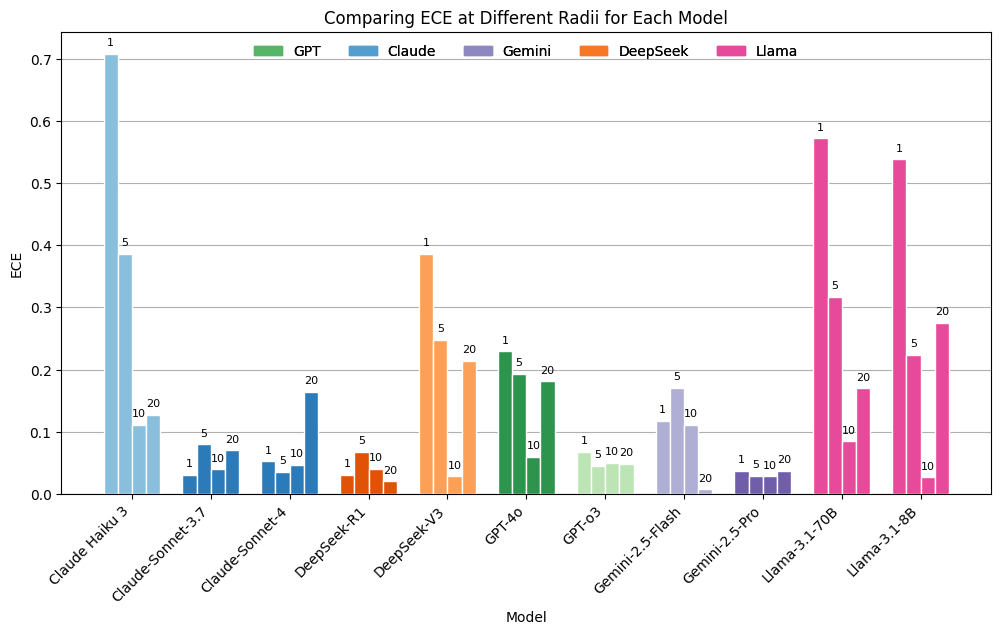

In [548]:

def plot_ece_life_eval():

    qset_name = 'LifeEval'
    gold_df_path = 'Formatted Benchmarks\\life_eval_formatted.csv'
    gold_df = pd.read_csv(gold_df_path)
    gold = gold_df['True Lifespan']

    act_table = pd.read_csv('Formatted Benchmarks\\PeriodLifeTable_2022_RawData.csv')

    global combined_data
    global combined
    combined_data = pd.DataFrame()
    combined = pd.DataFrame()

    for model_name, df in dfs[qset_name].items():

        # Get Radius
        radius_list = [1, 5, 10, 20]
        # Get the modulus of QID then use that as an index for radius_list such that 0-> 1, 1-> 5, 2-> 10, 3-> 20
        mod_qid = df['Question ID'].astype('int').apply(lambda x: x % 4)


        rads = mod_qid.apply(lambda i: radius_list[i])
        data = df[df['coerce'] == True].copy()

        #data['Radius'] = rads
        #data = score_life_eval(data, act_table.dropna())
        #agg_df = data.groupby("Radius")[['Score', 'Confidence']].apply(lambda g: get_ece(g["Score"], g["Confidence"])).reset_index()
        agg_df = data.groupby("Radius").apply(lambda g: get_ece(g["Score"], g["Confidence"]))
        agg_df = agg_df.rename("ECE").reset_index()


        agg_df['Model'] = model_name#.all()
        agg_df['Fam'] = model_family(model_name)

        combined_data = pd.concat([combined_data, data])
        combined = pd.concat([combined, agg_df])




    # Ensure Radius ordering
    radius_order = [1.0, 5.0, 10.0, 20.0]

    # Pivot table (rows = Model, cols = Radius)
    pivot = (
        combined.pivot_table(index="Model", columns="Radius", values= "ECE")
        .reindex(columns=radius_order).sort_values("Model")
    )



    fig, ax = plt.subplots(figsize=(12, 6))

    n_models = len(pivot.index)
    n_groups = len(pivot.columns)
    x = np.arange(n_models)
    bar_w = 0.18

    # Draw bars
    for i, r in enumerate(pivot.columns):
        colors = [pick_color(m) for m in pivot.index]
        bars = ax.bar(
            x + (i - (n_groups-1)/2)*bar_w,
            pivot[r].values,
            width=bar_w,
            color=colors,
            zorder=3,
            label=f"Radius {int(r)}" if i == 0 else "" , # legend for radius only once
            edgecolor = 'white'
        )
        # Add radius label at bottom above x-axis
        # add radius value on top of each bar
        for bar in bars:
            bar_x = bar.get_x() + bar.get_width() / 2
            bar_height = bar.get_height()
            ax.text(bar_x, bar_height + 0.01, f"{int(r)}", ha="center", va="bottom", fontsize=8)

    ax.set_ylabel("ECE")
    ax.set_xlabel('Model')
    ax.set_xticks(x)
    ax.set_xticklabels(pivot.index, rotation=45, ha="right")

    # Legends
    # 1. Radius legend (already handled by bar label)
    #ax.legend(title="Radius", loc="upper right", bbox_to_anchor = (1.05, 1.05))

    # 2. Family color legend
    families = ["GPT", "Claude", "Gemini", "DeepSeek", "Llama"]
    family_patches = [Patch(color=family_palettes[fam][3], label=fam) for fam in families]
    ax.add_artist(ax.legend(
    handles=family_patches,
    #title="Model Families",
    loc="upper center",
    bbox_to_anchor=(0.5, 1),   # centered below plot
    ncol=len(family_patches),     # one row
    frameon=False
))

    ax.axhline(0, color="black", linestyle="-", linewidth=0.75, zorder = 4) # y = 0 line for context

    ax.set_axisbelow(True)
    ax.grid(axis="y", zorder=0)
    ax.set_title('Comparing ECE at Different Radii for Each Model')
    plt.show()
    return fig, ax


plot, axes = plot_ece_life_eval()


In [518]:
data = dfs['LifeEval']['GPT-4o'].groupby("Radius")[['Score', 'Confidence']].apply(lambda g: get_ece(g["Score"], g["Confidence"])).reset_index()
data

,Radius,0
0,1,0.226530
1,5,0.175570
2,10,0.051982
3,20,0.177836


In [495]:
dfs['LifeEval']['GPT-4o']

,Unnamed: 0,Reasoning,Answer,Confidence,coerce,content,Question ID,Answer_prob,radius,Radius,Gender,Age,Score,Overconfidence
0,0,The life expectancy for an American male at bi...,76,0.1,True,"{\n ""Reasoning"": ""The life expectancy for a...",0,0.999997,1,1,male,0,0.046215,0.053785
1,1,The life expectancy for an American male at bi...,76,0.6,True,"{\n ""Reasoning"": ""The life expectancy for a...",1,0.999976,5,5,male,0,0.232835,0.367165
2,2,The life expectancy for an American male at bi...,76,0.6,True,"{\n ""Reasoning"": ""The life expectancy for a...",2,0.999993,10,10,male,0,0.469277,0.130723
3,3,The life expectancy for an American male is ap...,76,0.7,True,"{\n ""Reasoning"": ""The life expectancy for a...",3,0.999868,20,20,male,0,0.831361,-0.131361
4,4,The life expectancy for an American male at bi...,77,0.6,True,"{\n ""Reasoning"": ""The life expectancy for a...",4,0.592609,1,1,male,1,0.049337,0.550663
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
794,803,The life expectancy for an American female is ...,105,0.7,True,"{\n ""Reasoning"": ""The life expectancy for a...",803,0.999897,20,20,female,99,1.000000,-0.300000
795,804,The life expectancy for an American female is ...,105,0.3,True,"{\n ""Reasoning"": ""The life expectancy for a...",804,0.996974,1,1,female,100,0.104021,0.195979
796,805,The life expectancy for an American female who...,107,0.6,True,"{\n ""Reasoning"": ""The life expectancy for a...",805,0.999996,5,5,female,100,0.416123,0.183877
797,806,The life expectancy for an American female is ...,107,0.6,True,"{\n ""Reasoning"": ""The life expectancy for a...",806,0.758695,10,10,female,100,1.000000,-0.400000


### Gini Plots

In [ ]:
import time
def gini_plot(
        scores: pd.Series, 
        confidence: pd.Series, 
        n_bins: int = 10,
        model_name: str = '',
        qset_name: str = '',
        num_complete: int = None,
        title: str = None
        ):
    # Ensure inputs are numpy arrays
    scores = scores.astype(int).to_numpy()
    confidence = confidence.astype(float).to_numpy()
    
    # Calculate ECE and Accuracy
    ece = get_ece(pd.Series(scores), pd.Series(confidence), n_bins=n_bins)
    acc = np.mean(scores)

    melted = melt_series(score=scores, confidence=confidence)
    #display(melted)

    # Plot
    fig, ax = plt.subplots(figsize=(6, 6))

    ## Line of Well Calibration
    ax.plot([0, 1.1], [0, 1.1], linestyle='--', color='grey')

    ## Histogram:
    ax.bar(
        melted['mean_confidence'].fillna(0), 
        melted['count'].fillna(0) / melted['count'].sum(), 
        width=0.025, 
        align='center', 
        edgecolor='white',
        color = 'orange'
        )
    ax.scatter(melted['mean_confidence'], melted['mean_score'])


    ## Error Bars:
    # Standard error for a proportion
    stderr = np.sqrt((melted['mean_score'] * (1 - melted['mean_score'])) / melted['count'])
    stderr = stderr.fillna(0)  # no error if count = 0 or NaN

    ax.errorbar(melted['mean_confidence'], 
                melted['mean_score'], 
                yerr = stderr,  
                fmt='o', 
                ecolor='grey', 
                capsize=5,
                #linestyle = 'none'
                )
    
    ax.scatter(melted['mean_confidence'], melted['mean_score'], color = 'blue')


    # 45-degree reference line


    ax.set_xlim(0, 1.1)
    ax.set_ylim(0, 1.1)
    ax.set_xlabel('Gini Coefficient')
    ax.set_ylabel('Average Accuracy', labelpad= 15)
    if title is not None:
        ax.set_title(f'Accuracy: {acc:.3f} | n = {num_complete}')
    else:
        ax.set_title(f'Gini VS Accuracy for {model_name} on {qset_name}\nAccuracy: {acc:.3f} | n = {num_complete}' )
    ticks = [0, 0.1, 0.2, 0.3,0.4, 0.5, 0.6,0.7,0.7,0.8,0.9,1.0]
    labels = [0, 0.1, 0.2, 0.3,0.4, 0.5, 0.6,0.7,0.7,0.8,0.9,1.0]
    ax.set_xticks(ticks= ticks, labels=labels)

    # Create a secondary y-axis for proportion
    ax2 = ax.twinx()
    ax.set_ylim(0, 1.1)
    ax2.set_ylabel('Proportion of Gini Coefficients',rotation=-90, labelpad= 15)

    ax.set_ylim(0, 1.1)
    ax2.set_ylim(0, 1.1)
    #ax.grid(False)   # turn off grid for left axis
    #ax2.grid(False)  # turn off grid for right axis
    plt.show()

    # # --- Save Plot ---
    # filename = f"gini_plot_{qset_key.lower()}_{model_key}.png"
    # out_path = output_dir / "Calibration Plots"  / filename  # assumes output_dir exists
    # fig.savefig(out_path, dpi=300, bbox_inches="tight")
    # plt.close(fig)

    
    #plt.tight_layout()
    #plt.show()

    return ece, acc


test_df = dfs['SciQ']['Claude Haiku 3']

for qset_name, qset_dict in dfs.items():
    if qset_name in mcq_qsets:
        for name, df in qset_dict.items():
            gini_plot(scores= df['Score'], confidence= df['Gini'], model_name= name, qset_name= qset_name, num_complete= len(df))
            #time.sleep(10)


In [597]:

for qset_name, qset_dict in dfs.items():
    if qset_name in mcq_qsets:
        print(qset_name)
        sd_list = []
        for name, df in qset_dict.items():
            sd_gini = np.std(df['Gini'])
            acc =np.sum(df['Score'])
            #sd_list.append(sd_gini)
            print(f"    {name}----{acc}")

        print(f"    MEAN STD: {np.mean(sd_list)}")

LSAT-AR
    GPT-4o----31
    GPT-o3----83
    Claude-Sonnet-4----39
    Claude-Sonnet-3.7----36
    Claude Haiku 3----25
    Llama-3.1-8B----29
    Llama-3.1-70B----33
    Gemini-2.5-Pro----83
    Gemini-2.5-Flash----83
    DeepSeek-R1----83
    DeepSeek-V3----30
    MEAN STD: nan
SAT-EN
    GPT-4o----161
    GPT-o3----169
    Claude-Sonnet-4----171
    Claude-Sonnet-3.7----169
    Claude Haiku 3----153
    Llama-3.1-8B----145
    Llama-3.1-70B----159
    Gemini-2.5-Pro----171
    Gemini-2.5-Flash----171
    DeepSeek-R1----163
    DeepSeek-V3----164
    MEAN STD: nan
SciQ
    GPT-4o----964
    GPT-o3----976
    Claude-Sonnet-4----964
    Claude-Sonnet-3.7----968
    Claude Haiku 3----936
    Llama-3.1-8B----906
    Llama-3.1-70B----949
    Gemini-2.5-Pro----971
    Gemini-2.5-Flash----962
    DeepSeek-R1----972
    DeepSeek-V3----966
    MEAN STD: nan


C:\Users\Noam Michael\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Noam Michael\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


## Histogram of stated confidence

In [567]:
mcq_qsets

['LSAT-AR', 'SAT-EN', 'SciQ']

C:\Users\Noam Michael\AppData\Local\Temp\ipykernel_33336\2296900331.py:14: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  all_conf = pd.concat([all_conf, sc_vals], ignore_index=True).astype(float)


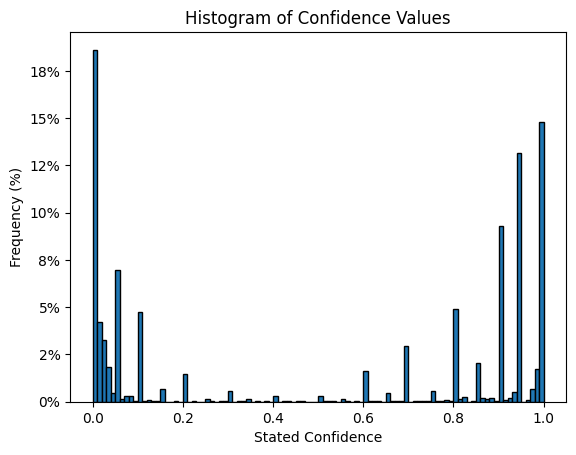

In [592]:
all_conf = pd.Series()
letters = ['A', 'B', 'C','D', 'E']

for qset, df_dict in dfs.items():
    for model, df in df_dict.items():
        if qset in mcq_qsets:

            sc_cols = list(set(df.columns) & set(letters))
            sc_vals = df[sc_cols].stack().reset_index(drop=True)
            
        else:
            sc_vals = df['Confidence']

        all_conf = pd.concat([all_conf, sc_vals], ignore_index=True).astype(float)

ax = all_conf.plot(
    kind="hist",
    bins=100,
    edgecolor="black",
    density=True
)

# scale y-axis to percent
ax.yaxis.set_major_formatter(lambda x, _: f"{x:.0f}%")

plt.xlabel("Stated Confidence")
plt.ylabel("Frequency (%)")
plt.title("Histogram of Confidence Values")
plt.show()

In [ ]:
all_conf 

0          0.7
1         0.95
2          0.8
3          0.9
4         0.95
          ... 
111601     0.1
111602     0.2
111603     0.0
111604     0.8
111605     0.0
Length: 111606, dtype: object

## Token Calibration Plots:

In [ ]:
# Make special plots for LifeEval because of the many fields

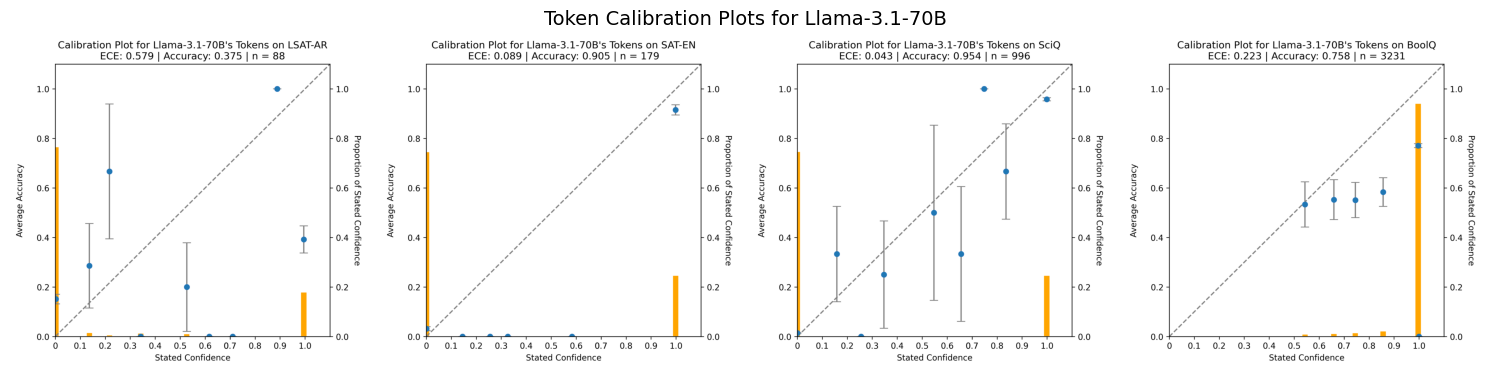

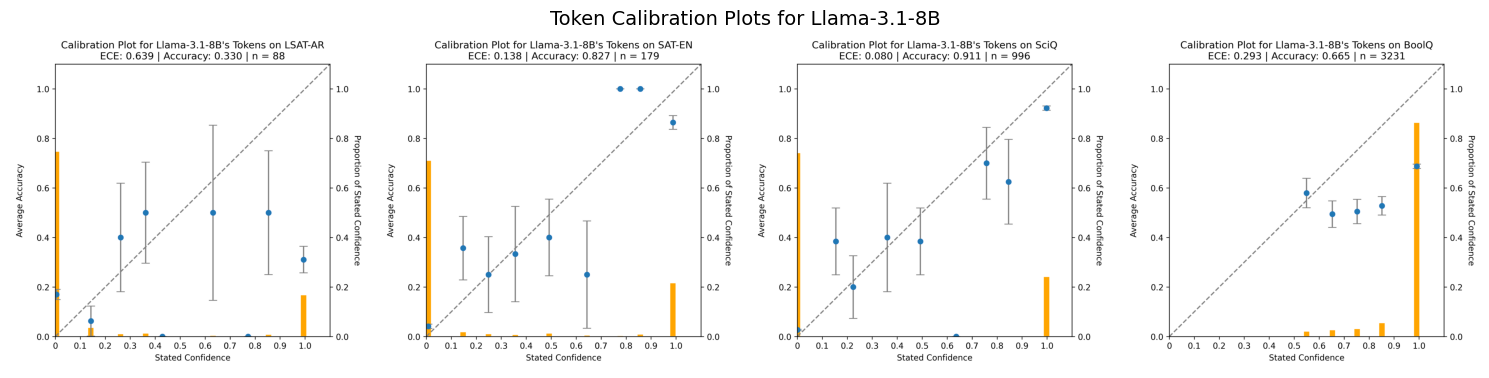

In [151]:
import matplotlib.image as mpimg



def side_by_side_plots(paths: tuple, title=  None):
    """
    Display three plots side by side given their file paths.

    Parameters
    ----------
    paths : tuple
        A tuple of three strings containing the file paths to the plots.
    """
    fig, axes = plt.subplots(1, len(paths), figsize=(15, 5))

    for ax, path in zip(axes, paths):
        img = mpimg.imread(path)
        ax.imshow(img)
        ax.axis("off")
    if title:
        fig.suptitle(title, fontsize=14, y = 0.85)
    plt.tight_layout()
    plt.show()

    return fig


llama_paths = (
    r'Plots\LSAT-AR\Calibration Plots\cal_plot_lsat_ar_test_Meta-Llama-3.1-70B-Instruct_tokens.png',
    r'Plots\SAT-EN\Calibration Plots\cal_plot_sat_en_Meta-Llama-3.1-70B-Instruct_tokens.png',
    r'Plots\SciQ\Calibration Plots\cal_plot_sciq_test_Meta-Llama-3.1-70B-Instruct_tokens.png',
    r'Plots\BoolQ\Calibration Plots\cal_plot_boolq_valid_Meta-Llama-3.1-70B-Instruct_tokens.png'
)

def plot_all(version = '70'):
    llama_paths = (
        r'Plots\LSAT-AR\Calibration Plots\cal_plot_lsat_ar_test_Meta-Llama-3.1-70B-Instruct_tokens.png',
        r'Plots\SAT-EN\Calibration Plots\cal_plot_sat_en_Meta-Llama-3.1-70B-Instruct_tokens.png',
        r'Plots\SciQ\Calibration Plots\cal_plot_sciq_test_Meta-Llama-3.1-70B-Instruct_tokens.png',
        r'Plots\BoolQ\Calibration Plots\cal_plot_boolq_valid_Meta-Llama-3.1-70B-Instruct_tokens.png'
    )

    llama_paths = tuple(x.replace("70", version) for x in llama_paths)
    
    title = 'Token Calibration Plots for Llama-3.1-70B'
    title = title.replace('70', version)

    fig = side_by_side_plots(llama_paths, title= title)

    path = f'Plots\\Summary Plots\\combined_cal_plot_llama_{version}B.png'
    fig.savefig(path, dpi=300, bbox_inches="tight")

plot_all('70')
plot_all('8')

In [275]:
only_llama

Llama-3.1-8B  Llama-3.1-70B
Question Set Metric                                      
BoolQ        accuracy            69.316820      78.585697
             n                 3200.000000    3241.000000
             ece                  0.170509       0.124427
             over_confidence      0.166593       0.120152
HaluEval     accuracy            52.122905      52.122905
             n                 1997.000000    1960.000000
             ece                  0.198719       0.143430
             over_confidence      0.190898       0.116056
LifeEval     accuracy            48.389434      53.521022
             n                  800.000000     807.000000
             ece                  0.141605       0.185064
             over_confidence      0.114641       0.185056
LSAT-AR      accuracy            31.395349      37.209302
             n                  190.000000     208.000000
             ece                  0.645930       0.534884
             over_confidence      0.637209       0.540698
             mean_gini            0.737301       0.750698
SAT-EN       accuracy            82.658960      91.907514
             n                  202.000000     202.000000
             ece                  0.096243       0.095607
             over_confidence      0.040462      -0.060925
             mean_gini            0.651413       0.631590
SciQ         accuracy            90.954774      95.376884
             n                  997.000000    1000.000000
             ece                  0.052332       0.042040
             over_confidence      0.038764      -0.007005
             mean_gini            0.717163       0.710729

In [379]:
llama_token_ece
only_llama_ece

,Llama-3.1-8B,Llama-3.1-70B,GPT-4o
Question Set,,,
BoolQ,0.171,0.124,0.080
HaluEval,0.199,0.143,0.245
LifeEval,0.142,0.185,0.085
LSAT-AR,0.646,0.535,0.498
SAT-EN,0.096,0.096,0.148
SciQ,0.052,0.042,0.054


In [383]:
# Token ECE vs Stated ECE

only_llama = table_df[['Llama-3.1-8B', 'Llama-3.1-70B', 'GPT-4o']]

only_llama_ece = only_llama.xs('ECE', level = 'Metric')
only_llama_ece


llama_token_ece['Llama-3.1-70B']
token_model_ece = pd.DataFrame(model_token_ece)

combined = pd.concat(
    [only_llama_ece, token_model_ece],
    axis=1,
    keys=["stated", "token"]  # creates a MultiIndex on columns
).drop('HaluEval')

flipped = combined.swaplevel(axis=1).sort_index(axis=1)
display(flipped)





GPT-4o           Llama-3.1-70B           Llama-3.1-8B          
         stated     token        stated     token       stated     token
BoolQ     0.080  0.160061         0.124  0.221109        0.171  0.290611
LifeEval  0.085  0.424451         0.185  0.306207        0.142  0.284362
LSAT-AR   0.498  0.701270         0.535  0.602912        0.646  0.667091
SAT-EN    0.148  0.068974         0.096  0.085598        0.096  0.135215
SciQ      0.054  0.031173         0.042  0.042718        0.052  0.079857

Index(['BoolQ', 'LifeEval', 'LSAT-AR', 'SAT-EN', 'SciQ'], dtype='object')

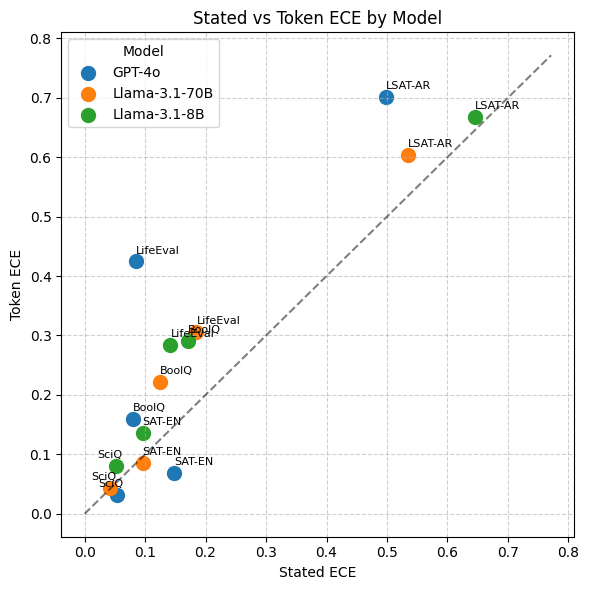

In [ ]:
## Instead of labels do it by shape?
# Prepare scatter plot
plt.figure(figsize=(6, 6))
plt.grid(True, linestyle='--', alpha=0.6)

# Diagonal reference line
lims = [0, max(flipped.max().max(), flipped.min().min()) * 1.1]
plt.plot(lims, lims, 'k--', alpha=0.5)

for model in flipped.columns.levels[0]:
    x = flipped[model]['stated']
    y = flipped[model]['token']
    plt.scatter(x, y, label=model, s=100, alpha = 1.0)

    #labels
    for xi, yi, label in zip(x, y, flipped.index):
        if label == 'SciQ':
            plt.text(
                xi + 0.01, yi +0.01, label,
                fontsize=8,
                ha="right", va="bottom"
            )
        else:
            plt.text(
                xi, yi +0.01, label,
                fontsize=8,
                ha="left", va="bottom"
            )




plt.xlabel("Stated ECE")
plt.ylabel("Token ECE")
plt.title("Stated vs Token ECE by Model")
plt.legend(title="Model")

plt.tight_layout()

#plt.show()
plt.savefig("Plots\\Summary Plots\\sc_ece_vs_tp_ece_llama", dpi = 450)

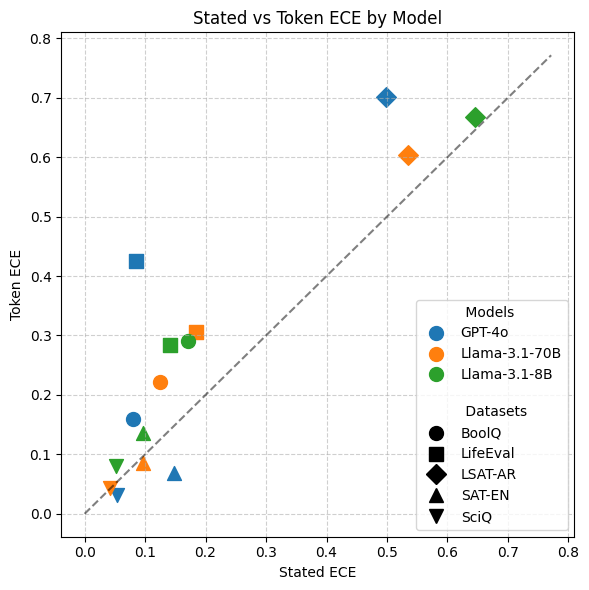

In [487]:
import matplotlib.lines as mlines
# explicit colors for models
model_colors = {
    "GPT-4o": "tab:blue",
    "Llama-3.1-70B": "tab:orange",
    "Llama-3.1-8B": "tab:green",
}

# explicit shapes for datasets
dataset_markers = {
    "BoolQ": "o",
    "LifeEval": "s",
    "LSAT-AR": "D",
    "SAT-EN": "^",
    "SciQ": "v",
}

plt.figure(figsize=(6, 6))
plt.grid(True, linestyle="--", alpha=0.6)

# diagonal reference line
lims = [0, max(flipped.max().max(), flipped.min().min()) * 1.1]
plt.plot(lims, lims, "k--", alpha=0.5)

# plot each point with (color=model, marker=dataset)
for model in flipped.columns.levels[0]:
    for dataset in flipped.index:
        xi = flipped.loc[dataset, (model, "stated")]
        yi = flipped.loc[dataset, (model, "token")]
        plt.scatter(
            xi,
            yi,
            color=model_colors[model],
            marker=dataset_markers[dataset],
            s=100,
        )

plt.xlabel("Stated ECE")
plt.ylabel("Token ECE")
plt.title("Stated vs Token ECE by Model")

# legend 1: models (colors only)
for model, c in model_colors.items():
    plt.scatter([], [], color=c, marker="o", s=100, label=model)
#legend1 = plt.legend(title="Model", loc="upper left")

# legend 2: datasets (shapes only, black)
for dataset, m in dataset_markers.items():
    plt.scatter([], [], color="k", marker=m, s=100, label=dataset)
#legend2 = plt.legend(title="Legend", loc="lower right")

#plt.gca().add_artist(legend1)  # keep both legends

# dummy "header" entries
header_models = mlines.Line2D([], [], color="none", label=" Models ")
header_datasets = mlines.Line2D([], [], color="none", label="\n Datasets ")

# model handles (colors only)
model_handles = [plt.Line2D([], [], color=c, marker='o', linestyle='', markersize=10, label=m)
                 for m, c in model_colors.items()]

# dataset handles (shapes only)
dataset_handles = [plt.Line2D([], [], color='k', marker=mk, linestyle='', markersize=10, label=d)
                   for d, mk in dataset_markers.items()]

plt.legend(handles=[header_models] + model_handles + [header_datasets] + dataset_handles,
           loc="lower right")


plt.tight_layout()

## Average Stated Conf v. Token Prob


In [460]:
dfs['BoolQ']['Llama-3.1-70B']


llama_70_dfs = {}
llama_8_dfs = {}
gpt_4_dfs = {}
for dataset in dfs:
    llama_70_dfs[dataset] = dfs[dataset]['Llama-3.1-70B']
    llama_8_dfs[dataset] = dfs[dataset]['Llama-3.1-8B']
    gpt_4_dfs[dataset] = dfs[dataset]['GPT-4o']

    
token_dfs = {
    'GPT-4o': gpt_4_dfs,
    'Llama-3.1-70B': llama_70_dfs,
    'Llama-3.1-8B': llama_8_dfs,

}


In [418]:
df.columns

Index(['Unnamed: 0', 'Question ID', 'Answer', 'A', 'B', 'C', 'D', 'E',
       'coerce', 'content', 'Question ID.1', 'A_prob', 'B_prob', 'C_prob',
       'D_prob', 'E_prob', 'Correct Answer Letter', 'Gini', 'Score'],
      dtype='object')

In [490]:
mcq_qsets =['LSAT-AR', 'SAT-EN', 'SciQ']
letters = ['A', 'B', 'C', 'D', 'E']

model_diffs = {}

for model, df_dict in token_dfs.items():
    print(model)
    diff_s  = pd.Series()
    model_diffs[model] = {}
    for qset_display, df in df_dict.items():
        if qset_display == 'HaluEval':
            continue
        model_diffs[model][qset_display] = {}

        print(f"    {qset_display}")
        if qset_display in mcq_qsets:

            sc_cols = list(set(df.columns) & set(letters))
            sc = df[sc_cols].max(axis=1).astype(float)
        else:
            sc = df['Confidence'].astype(float)
        prob_cols = [c for c in df.columns if c.endswith("_prob")]
        tp = df[prob_cols].max(axis=1).astype(float)
        diff = sc - tp
        print(f"        Mean sc: {np.mean(sc)}")
        print(f"        Mean tp: {np.mean(tp)}")
        print(f"        Mean difference: {np.mean(diff)}")



        diff_s = pd.concat([diff_s, diff])
        # if qset_display == 'LSAT-AR':
        #     break
        print(f"        ")
        model_diffs[model][qset_display] = np.mean(diff)


GPT-4o
    BoolQ
        Mean sc: 0.9251882315722871
        Mean tp: 0.9911270572332315
        Mean difference: -0.0659388256609441
        
    LifeEval
        Mean sc: 0.5954317897371714
        Mean tp: 0.93720388222281
        Mean difference: -0.3417720924856386
        
    LSAT-AR
        Mean sc: 0.8303468208092486
        Mean tp: 0.9960676859413056
        Mean difference: -0.16572086513205697
        
    SAT-EN
        Mean sc: 0.7883838383838385
        Mean tp: 0.9982671274687002
        Mean difference: -0.20988328908486198
        
    SciQ
        Mean sc: 0.9194583751253761
        Mean tp: 0.9998401332262672
        Mean difference: -0.08038175810089111
        
Llama-3.1-70B
    BoolQ
        Mean sc: 0.8952609933565328
        Mean tp: 0.9816274220908089
        Mean difference: -0.08636642873427601
        
    LifeEval
        Mean sc: 0.7206758448060074
        Mean tp: 0.7161411481148311
        Mean difference: 0.004534696691176471
        
    LSAT-AR
    

C:\Users\Noam Michael\AppData\Local\Temp\ipykernel_33336\2429034127.py:31: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  diff_s = pd.concat([diff_s, diff])
C:\Users\Noam Michael\AppData\Local\Temp\ipykernel_33336\2429034127.py:31: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  diff_s = pd.concat([diff_s, diff])
C:\Users\Noam Michael\AppData\Local\Temp\ipykernel_33336\2429034127.py:31: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result

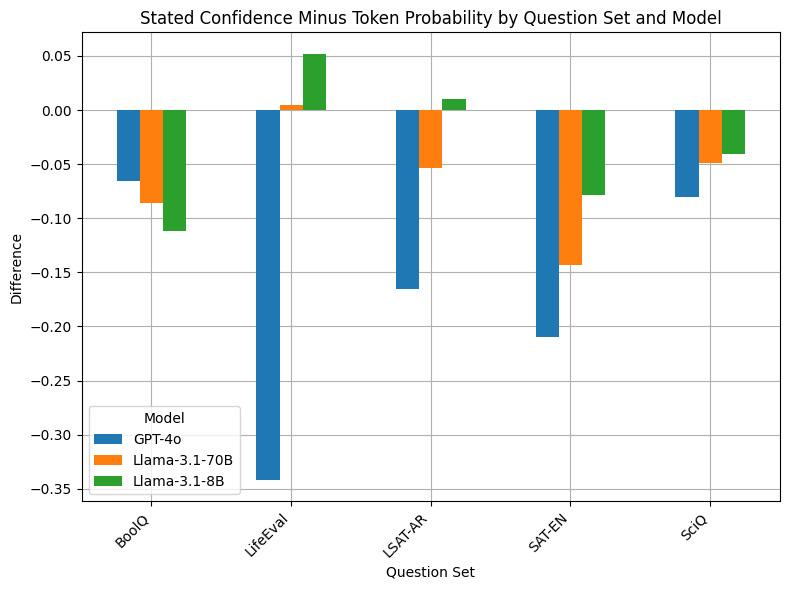

In [594]:
diff_df = pd.DataFrame(model_diffs)


ax = diff_df.plot(kind="bar", figsize=(8, 6), grid = True)
ax.set_axisbelow(True) 
plt.xlabel("Question Set")

plt.ylabel("Difference")
plt.title("Stated Confidence Minus Token Probability by Question Set and Model")
plt.xticks(rotation=45, ha="right")
plt.legend(title="Model")
plt.tight_layout()
plt.show()